## Подгрузка всех необходимых библиотек

In [47]:
!pip install pandarallel

In [61]:
# База
import re
import time
import string
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import unicodedata
from pandarallel import pandarallel
import matplotlib.pyplot as plt
from collections import Counter
from joblib import Parallel, delayed
import multiprocessing
from itertools import chain, islice
from wordcloud import WordCloud
from tqdm.notebook import tqdm
tqdm.pandas()
import seaborn as sns
# Работа с NLP
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

## Описание набора данных

#### Основные переменные
- `comment_text` - текст комментария.
- `toxicity` - доля аннотаторов, оценивших комментарий как токсичный (от 0.0 до 1.0). Если `target >= 0.5`, комментарий считается токсичным.
- `severe_toxicity` - доля аннотаторов, посчитавших комментарий крайне токсичным.(Любой комментарий, который считался крайне токсичным, также считался токсичным.)
- `obscene` - доля аннотаторов, отметивших комментарий как непристойный.
- `threat` - доля аннотаторов, посчитавших комментарий угрожающим.
- `insult` - доля аннотаторов, оценивших комментарий как оскорбительный.
- `identity_attack` - доля аннотаторов, отметивших, что в комментарии присутствует атака на идентичность.
- `sexual_explicit` - доля аннотаторов, отметивших комментарий как содержащий сексуально явный контент.

#### Идентичности (упоминания социальных групп)

- `male` - доля аннотаторов, посчитавших, что в комментарии упоминается идентичность "мужчина".
- `female` - доля аннотаторов, отметивших идентичность "женщина".
- `transgender` - доля аннотаторов, отметивших идентичность "трансгендер".
- `other_gender` - доля аннотаторов, отметивших другие гендерные идентичности.

##### Сексуальная ориентация
- `heterosexual` - доля аннотаторов, отметивших идентичность "гетеросексуал".
- `homosexual_gay_or_lesbian` - доля аннотаторов, отметивших идентичность "гомосексуал/гей или лесбиянка".
- `bisexual` - доля аннотаторов, отметивших идентичность "бисексуал".
- `other_sexual_orientation` - доля аннотаторов, отметивших другие сексуальные ориентации.

##### Религия
- `christian` - доля аннотаторов, отметивших идентичность "христианин".
- `jewish` - доля аннотаторов, отметивших идентичность "еврей".
- `muslim` - доля аннотаторов, отметивших идентичность "мусульманин".
- `hindu` - доля аннотаторов, отметивших идентичность "индуист".
- `buddhist` - доля аннотаторов, отметивших идентичность "буддист".
- `atheist` - доля аннотаторов, отметивших идентичность "атеист".
- `other_religion` - доля аннотаторов, отметивших другие религиозные идентичности.

##### Раса и этническая принадлежность
- `black` - доля аннотаторов, отметивших идентичность "чернокожий".
- `white` - доля аннотаторов, отметивших идентичность "белый".
- `asian` - доля аннотаторов, отметивших идентичность "азиат".
- `latino` - доля аннотаторов, отметивших идентичность "латиноамериканец".
- `other_race_or_ethnicity` - доля аннотаторов, отметивших другие расы или этнические группы.

##### Инвалидность
- `physical_disability` - доля аннотаторов, отметивших идентичность "физическая инвалидность".
- `intellectual_or_learning_disability` - доля аннотаторов, отметивших идентичность "умственная или обучаемая инвалидность".
- `psychiatric_or_mental_illness` - доля аннотаторов, отметивших идентичность "психиатрическое или психическое заболевание".
- `other_disability` - доля аннотаторов, отметивших другие инвалидности.

#### Метаданные

- `created_date` - дата создания комментария.
- `id`, `publication_id`, `parent_id`, `article_id` - идентификаторы публикаций и родительских комментариев.
- `rating` - рейтинг комментария, присвоенный пользователями платформы Civil Comments.
- `funny`, `wow`, `sad`, `likes`, `disagree` - пользовательские оценки (количество реакций, например, лайков, дизлайков и т.д.).
- `toxicity_annotator_count` - количество аннотаторов, которые оценили токсичность комментария.
- `identity_annotator_count` - количество аннотаторов, которые оценили упоминание идентичностей в комментарии.

In [62]:
df = (pd.read_csv(
    '/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/train.csv',
    parse_dates=['created_date'],
    date_format='ISO8601',
    index_col = 0
).rename(columns={'target': 'toxicity'}))

In [63]:
df.head()

,toxicity,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.00,"This is so cool. It's like, 'would you want yo...",0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.00,0,4
59849,0.00,Thank you!! This would make my life a lot less...,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.00,0,4
59852,0.00,This is such an urgent design problem; kudos t...,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.00,0,4
59855,0.00,Is this something I'll be able to install on m...,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.00,0,4
59856,0.89,haha you guys are a bunch of losers.,0.02,0.00,0.02,0.87,0.00,0.00,0.00,0.00,...,2006,rejected,0,0,0,1,0,0.00,4,47


In [64]:
target_cols = ['toxicity', 'comment_text']

toxic_cols = ['toxicity','severe_toxicity',
               'obscene','identity_attack',
               'insult','threat','sexual_explicit']

identity_cols = ['asian','atheist','bisexual',
                 'black','buddhist','christian',
                 'female','heterosexual','hindu',
                 'homosexual_gay_or_lesbian',
                 'intellectual_or_learning_disability',
                 'jewish','latino','male','muslim',
                 'other_disability','other_gender',
                 'other_race_or_ethnicity','other_religion',
                 'other_sexual_orientation','physical_disability',
                 'psychiatric_or_mental_illness','transgender','white']

c_meta_cols = ['created_date', 'publication_id',
               'parent_id','article_id','rating',
               'funny','wow','sad','likes','disagree']

a_meta_cols = ['toxicity_annotator_count',
               'identity_annotator_count']

### Базовый Анализ

Для начала посмотрим на краткую информацию о наборе данных с помощью метода `.info()`

In [65]:
df.info(show_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 1804874 entries, 59848 to 6334010
Data columns (total 44 columns):
 #   Column                               Non-Null Count    Dtype              
---  ------                               --------------    -----              
 0   toxicity                             1804874 non-null  float64            
 1   comment_text                         1804871 non-null  object             
 2   severe_toxicity                      1804874 non-null  float64            
 3   obscene                              1804874 non-null  float64            
 4   identity_attack                      1804874 non-null  float64            
 5   insult                               1804874 non-null  float64            
 6   threat                               1804874 non-null  float64            
 7   asian                                405130 non-null   float64            
 8   atheist                              405130 non-null   float64            
 9   bis

Как можно заметить набор данных довольно большой и имеет 45 стобцов и 1804874 строк. Все типы данных определены корректно. Однако уже сейчас можно заметить, что в данных для переменных отражающих упоминание в комеменнатриях определенных социальных групп лишь 405130 строк имеют какие-либо значения отличные от `N/A`.

### N/A

Рассмотрим переменные, в которых имеются значения `N/A`

In [66]:
df.isna().sum()[df.isna().sum() > 0]

comment_text                                 3
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male                                   1399744
muslim                                 1399744
other_disability                       1399744
other_gender                           1399744
other_race_or_ethnicity                1399744
other_religion                         1399744
other_sexual_orientation               1399744
physical_disa

In [67]:
round(1 - (1399744/len(df)), 3)

0.224

In [68]:
round((778646/len(df)), 3)

0.431

In [69]:
len(df[df.identity_annotator_count != 0])

405130

Исходя из полученных выше данных, хорошо заметно, что примерно 78% строк не имеют в себе информации об упоминании каких либо социальных группах в комментариях. При этом значения N/A означают, что попросту анотаторы не оценивали упоминание каких либо социальных групп в этих комментариях. Таким образом, есть два пути работы со столбцами, которые оторажают упоминание социальных групп:

- удаление строк, в которых нет данных в этих столбцах
- удаление стобцов с этими данными

В первом варианте мы лишаемся 78% наблюдений в данных, а во втором только этих столбцов. Команда больше настроена на 2 вариант. Поэтому после непродолжительного анализа столбцы с этими данными будут вырезаны из набора данных для анализа.

Так же стоит рассказать что-то и про другие переменные со значениями N/A. В случае с переменной `comment_text` такие значения будут удалены, так как нам крайне важны тексты комментариев для дальнейшего построения моделей в будущем. В случае с переменной `parent_id` значения N/A вероятно означают то, что данный комментарий сам по себе является родительским. Судя по всему в выборке у нас таких комментариев примено 43%.

In [70]:
df = (df.dropna(subset='comment_text'))

### Дубликаты в данных

Перейдем к рассмотрению дубликатов

In [71]:
df.comment_text.duplicated().sum()

24049

Всего дубликатов комментариев в наборе данных 24051. Посмотрим теперь на 10 наиболее повторяющихся комментариев.

In [72]:
df[df.toxicity >= 0.4].comment_text.value_counts()[:10].to_frame() #для комментариев с toxicity >= 0.4

,count
comment_text,
"H.L. MENCKEN’S prediction:\n\n“As democracy is perfected, the office of the President represents, more and more closely, the inner soul of the people. On some great and glorious day, the plain folks of the Land will reach their heart’s desire at last, and the White House will be occupied by a downright fool and complete narcissist moron.”\n\n -H.L. Mencken\nThe Baltimore Evening Sun,\nJuly 26, 1920",32
"Nicky, you can't handle the truth. Both Harper and Harris were completely useless scumbags. One was the worst PM we will ever have, and the other is the worst Ontario Premier we will ever have. You can sling all the sing-song baloney you want, they were the worst.",24
"The domestic terrorists at the company called ""civil comments"" are attempting to destroy your first amendment right to free speech!\nOnly in communist countries or in Nazi Germany you had to have approval of your speech by your peers!\nThat's not the United States of America!\nThat's Russia under the iron fist of a loser named Putin!\nRESIST LOSING YOUR 1st Amendment right!\nHere is the communists website I HOPE all hackers that are reading this understand it is time to take this website down are you listening @ ""anonymous"" our free-speech is being destroyed by these losers\nBe a real American patriot like Thomas Jefferson and George Washington that fought for our first amendment rights for free speech !\nhttps://www.getcivil.com",22
That's just silly.,20
You're an idiot.,19
Disgusting.,18
Pathetic.,17
Troll,17
"Trudeau, you terrorist sympathizer....",17


In [73]:
df.comment_text.value_counts()[:10].to_frame() #для всех комменатриев

,count
comment_text,
Well said.,184
No.,160
Exactly.,132
Yes.,127
Thank you.,120
Why?,118
"Sᴛᴀʀᴛ ᴡᴏʀᴋɪɴɢ ғʀᴏᴍ ʜᴏᴍᴇ! Gʀᴇᴀᴛ ᴊᴏʙ ғᴏʀ sᴛᴜᴅᴇɴᴛs, sᴛᴀʏ-ᴀᴛ-ʜᴏᴍᴇ ᴍᴏᴍs ᴏʀ ᴀɴʏᴏɴᴇ ɴᴇᴇᴅɪɴɢ ᴀɴ ᴇxᴛʀᴀ ɪɴᴄᴏᴍᴇ... Yᴏᴜ ᴏɴʟʏ ɴᴇᴇᴅ ᴀ ᴄᴏᴍᴘᴜᴛᴇʀ ᴀɴᴅ ᴀ ʀᴇʟɪᴀʙʟᴇ ɪɴᴛᴇʀɴᴇᴛ ᴄᴏɴɴᴇᴄᴛɪᴏɴ... Mᴀᴋᴇ $90 ʜᴏᴜʀʟʏ ᴀɴᴅ ᴜᴘ ᴛᴏ $12000 ᴀ ᴍᴏɴᴛʜ ʙʏ ғᴏʟʟᴏᴡɪɴɢ ʟɪɴᴋ ᴀᴛ ᴛʜᴇ ʙᴏᴛᴛᴏᴍ ᴀɴᴅ sɪɢɴɪɴɢ ᴜᴘ... Yᴏᴜ ᴄᴀɴ ʜᴀᴠᴇ ʏᴏᴜʀ ғɪʀsᴛ ᴄʜᴇᴄᴋ ʙʏ ᴛʜᴇ ᴇɴᴅ ᴏғ ᴛʜɪs ᴡᴇᴇᴋ... \n\n+++++++++http://www.cashapp24.com/",117
Exactly!,103
Well said!,100


- Если рассматривать все комментарии, то видно, что многие комментарие довольно-таки типовые. Также видно, что среди комментариев есть спам с рекламой, который также довольно часто повторяется (больше 100 раз).

- Если рассматривать комментарии с `toxicity >= 0.4`, то видно, что среди повторяющихся комментариев довольно много типовых токсичных фраз, а также довольно таки большие скопированные токсичные комментарии похожие на спам.

- Стоит отмеить, что повторяющихся комментариев намного меньше среди токсичных комментариев. Однако это может быть связанно с дисбалансом в наборе данных

Было принято решение не избавляться от дубликатов типовых фраз, так как этим мы нарушим соответствие данных генеральной совокупности. Из данных будет удален только различный повторяющийся спам. Будет оставлено по одному экземпляру каждого спама, так как среди него есть и токсичный спам. При этом будут оставлены только те строки, у которых значение `toxicity_annotator_count` максимальное. Это сделано исходя из того, что перемнная `toxicity` отражает долю аннотаторов посчитавших комментарий токсичным и чем больше аннотаторов принемало участие, тем более объективной оценкой токсичности является данная переменная. Чтобы это осуществить набор данных будет отсортирован по данным значениям, а затем будет применен метод `.drop_duplicates()` с параметром `keep='first'`. 

In [74]:
df['text_length'] = df.comment_text.apply(len)
df[df.text_length > 35].comment_text.value_counts()[:5] #для всех комменатриев

comment_text
Sᴛᴀʀᴛ ᴡᴏʀᴋɪɴɢ ғʀᴏᴍ ʜᴏᴍᴇ! Gʀᴇᴀᴛ ᴊᴏʙ ғᴏʀ sᴛᴜᴅᴇɴᴛs, sᴛᴀʏ-ᴀᴛ-ʜᴏᴍᴇ ᴍᴏᴍs ᴏʀ ᴀɴʏᴏɴᴇ ɴᴇᴇᴅɪɴɢ ᴀɴ ᴇxᴛʀᴀ ɪɴᴄᴏᴍᴇ... Yᴏᴜ ᴏɴʟʏ ɴᴇᴇᴅ ᴀ ᴄᴏᴍᴘᴜᴛᴇʀ ᴀɴᴅ ᴀ ʀᴇʟɪᴀʙʟᴇ ɪɴᴛᴇʀɴᴇᴛ ᴄᴏɴɴᴇᴄᴛɪᴏɴ... Mᴀᴋᴇ $90 ʜᴏᴜʀʟʏ ᴀɴᴅ ᴜᴘ ᴛᴏ $12000 ᴀ ᴍᴏɴᴛʜ ʙʏ ғᴏʟʟᴏᴡɪɴɢ ʟɪɴᴋ ᴀᴛ ᴛʜᴇ ʙᴏᴛᴛᴏᴍ ᴀɴᴅ sɪɢɴɪɴɢ ᴜᴘ... Yᴏᴜ ᴄᴀɴ ʜᴀᴠᴇ ʏᴏᴜʀ ғɪʀsᴛ ᴄʜᴇᴄᴋ ʙʏ ᴛʜᴇ ᴇɴᴅ ᴏғ ᴛʜɪs ᴡᴇᴇᴋ... \n\n+++++++++http://www.cashapp24.com/                                                                                                                                                                                                                                                                                                                                                                                                      117
Start working at home with Google! It's by-far the best job I've had. Last Wednesday I got a brand new BMW since getting a check for $6474 this - 4 weeks past. I began this 8-months ago and immediately was bringing home at least $77 per hou

In [75]:
df = (df.sort_values(by='toxicity_annotator_count', ascending=False)[~((df.duplicated(keep='first'))&(df.text_length > 35))])

/tmp/ipykernel_30/4275472313.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = (df.sort_values(by='toxicity_annotator_count', ascending=False)[~((df.duplicated(keep='first'))&(df.text_length > 35))])


### Описательные статистики

Начнем с числовых переменных

In [76]:
df[toxic_cols].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95])

,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
count,1804871.00,1804871.00,1804871.00,1804871.00,1804871.00,1804871.00,1804871.00
mean,0.10,0.00,0.01,0.02,0.08,0.01,0.01
std,0.20,0.02,0.06,0.08,0.18,0.05,0.05
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5%,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10%,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00
60%,0.00,0.00,0.00,0.00,0.00,0.00,0.00
70%,0.00,0.00,0.00,0.00,0.00,0.00,0.00


На таблице выше представлены описательные статистики для переменных отражающих токсичность комментариев для разнынных подтипов токсичности. По ней видно, что в данных исходя из распределения для всех этих переменных подавляющее большинство наблюдений имеют значения 0. Только где-то к 70 перцентилю значения переменной `toxicity` становятся чуть выше. Однако порог в 0.4 пересекается только где-то между в 90 перцентиле. Если рассматривать подтипы токсичности, то еще больше наблюдений в данных имеют в этих переменных 0. Исключением является переменная `insult`. Все это говорит о том, что в данных наблюдается довольно сильный дисбаланс относительно количества токсичных и не токсичных комментариев и в особенности их подтипов.

In [78]:
df[identity_cols[:10]].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95])

,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian
count,405128.00,405128.00,405128.00,405128.00,405128.00,405128.00,405128.00,405128.00,405128.00,405128.00
mean,0.01,0.00,0.00,0.03,0.00,0.10,0.13,0.00,0.00,0.03
std,0.09,0.05,0.03,0.17,0.03,0.26,0.31,0.05,0.03,0.14
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
60%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
70%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [79]:
df[~df.asian.isna()][identity_cols[10:]].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95,0.99])

,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white
count,405128.00,405128.00,405128.00,405128.00,405128.00,405128.00,405128.00,405128.00,405128.00,405128.00,405128.00,405128.00,405128.00,405128.00
mean,0.00,0.02,0.01,0.11,0.05,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.01,0.06
std,0.02,0.12,0.06,0.27,0.20,0.01,0.01,0.04,0.04,0.02,0.02,0.09,0.07,0.22
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
60%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
70%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Для переменных связанных с упоминанием каких-либо социальных групп в комментариях в таблице с описательными статистиками можно заметить еще больший дисбаланс в распределении, чем у переменных связанных с токсичностью. Для большинства переменных средним является 0 или среднее стремится к нему. Также у большинства переменных 95 перцентиль явяляется 0. Стоит учитывать, что метод `describe` затрагивает только ту часть набора данных, в которой значения данных переменных не являются значениями `N/A`. Эти переменные, конечно можно еще использовать для какого-то анализа, но учитывая отсутствия значений и дисбаланс распределения, скорее всего их придется удалить из рассмотрения после него.

In [80]:
df[c_meta_cols[4:]].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95,0.99])

,funny,wow,sad,likes,disagree
count,1804871.00,1804871.00,1804871.00,1804871.00,1804871.00
mean,0.28,0.04,0.11,2.45,0.58
std,1.06,0.24,0.46,4.73,1.87
min,0.00,0.00,0.00,0.00,0.00
5%,0.00,0.00,0.00,0.00,0.00
10%,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,1.00,0.00
60%,0.00,0.00,0.00,1.00,0.00
70%,0.00,0.00,0.00,2.00,0.00


Исходя из построенной выше таблицы, можно заметить, что какие-либо другие реакции кроме лайков для комментариев в рассматриваемых данных доавольно редки. Возможно стоит преобразовать данные переменные в одну.

In [81]:
df[~df.asian.isna()][a_meta_cols[1:]].describe()

,identity_annotator_count
count,405128.00
mean,6.41
std,37.29
min,4.00
25%,4.00
50%,4.00
75%,6.00
max,1866.00


In [82]:
df[a_meta_cols[0]].describe().to_frame()

,toxicity_annotator_count
count,1804871.00
mean,8.78
std,43.50
min,3.00
25%,4.00
50%,4.00
75%,6.00
max,4936.00


Распределения количества аннотаторов как для идентичности, так и для токсичности весьма схожи. Наблюдаются довольно сильные выбросы для обеих переменных. В дальнейшем будет необходимо рассмотреть аномалию, в особенности для переменной `toxicity_annotator_count`. Стоит отметить, что посторения описательных статистик для переменной `identity_annotator_count` использовалась только та часть выборки, в которой значения для перемнных отражающих упоминание социальных групп в комментариях не равны `N/A`. Распределение для этой переменной в случае включения всех строк немного иное.

In [83]:
df[a_meta_cols[1:]].describe()

,identity_annotator_count
count,1804871.00
mean,1.44
std,17.87
min,0.00
25%,0.00
50%,0.00
75%,0.00
max,1866.00


Рассмотрим теперь описательные статистики для типа данных `object`

In [84]:
df.describe(include='object')

,comment_text,rating
count,1804871,1804871
unique,1780822,2
top,Well said.,approved
freq,184,1684755


In [85]:
1684755 / len(df)

0.9334489833345431

Тут на самом деле мало, что можно сказать. В наборе данных после удаления дубликатов все значения уникальны для переменной `comment_text`. А для перемеменной `rating` всего два униакльных значения, среди которых значение `'approved'` соответствует 93.5 % всех данных.

### Анализ для социальных групп

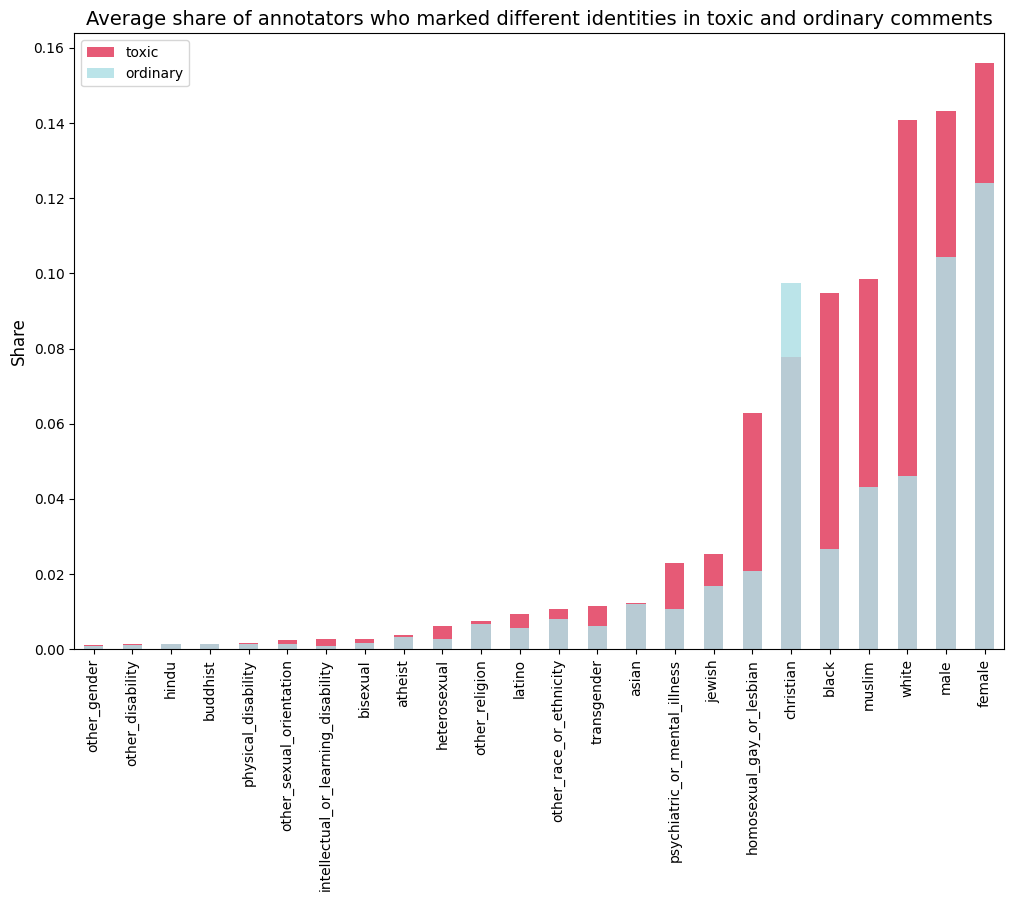

In [86]:
plt.figure(figsize=(12, 8))
cols = df[(df.toxicity >= 0.5)&(~df.asian.isna())][identity_cols].mean().sort_values().index.values
df[(df.toxicity >= 0.5)&(~df.asian.isna())][cols].mean().plot(kind='bar', color = 'crimson', alpha = 0.7, label = 'toxic')
df[(df.toxicity < 0.5)&(~df.asian.isna())][cols].mean().plot(kind='bar', color='powderblue', alpha = 0.85, label = 'ordinary')
plt.title('Average share of annotators who marked different identities in toxic and ordinary comments', fontsize=14)
plt.ylabel('Share', fontsize=12)
plt.legend()

plt.show()

По графику можно увидеть, что в среднем доли аннотаторов которые отметили упоминание социальных идентичностей связанных с переменными `female`, `male`, `white`, `black`, `muslim`, `homosexual_gay_or_lesbian` и т.д. выше для токсичных комментариев, чем для обычных, а для переменной `christian` средняя доля выше для обычных комментариев. Некоторые идентичности, такие как `buddhist` и `hindu`, упоминаются редко в обоих типах комментариев.

Удалим колонки связанные с социалными идентичностями, так как для дальнейшего анализа они не представляют интереса (Плюс они задействуют относительно много рессурсов). Также удалим колонки, которые в EDA не будут рассматриваться `publication_id`, `article_id`.

In [87]:
df.drop(columns = identity_cols + ['publication_id', 'article_id'], inplace=True)

In [88]:
df.info(show_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 1804871 entries, 5118044 to 435840
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype              
---  ------                    --------------    -----              
 0   toxicity                  1804871 non-null  float64            
 1   comment_text              1804871 non-null  object             
 2   severe_toxicity           1804871 non-null  float64            
 3   obscene                   1804871 non-null  float64            
 4   identity_attack           1804871 non-null  float64            
 5   insult                    1804871 non-null  float64            
 6   threat                    1804871 non-null  float64            
 7   created_date              1804871 non-null  datetime64[ns, UTC]
 8   parent_id                 1026225 non-null  float64            
 9   rating                    1804871 non-null  object             
 10  funny                     1804871 non-null  int64     

### Временной анализ комментариев

Для начала добавим в данные переменные `year` и `year_month`, чтобы затем проанализировать их. Также добавим бинарную переменную `toxicity_b`, которая поделит комментарии на токсичные и обычные комментарии исходя из изначального порога `toxicity >= 0.4`

In [89]:
df['year'] = df.created_date.dt.year.astype(str)
df['year_month'] = df.created_date.dt.tz_localize(None).to_numpy().astype('datetime64[M]')
df['toxicity_b'] = (df.toxicity >= 0.4).astype(int)

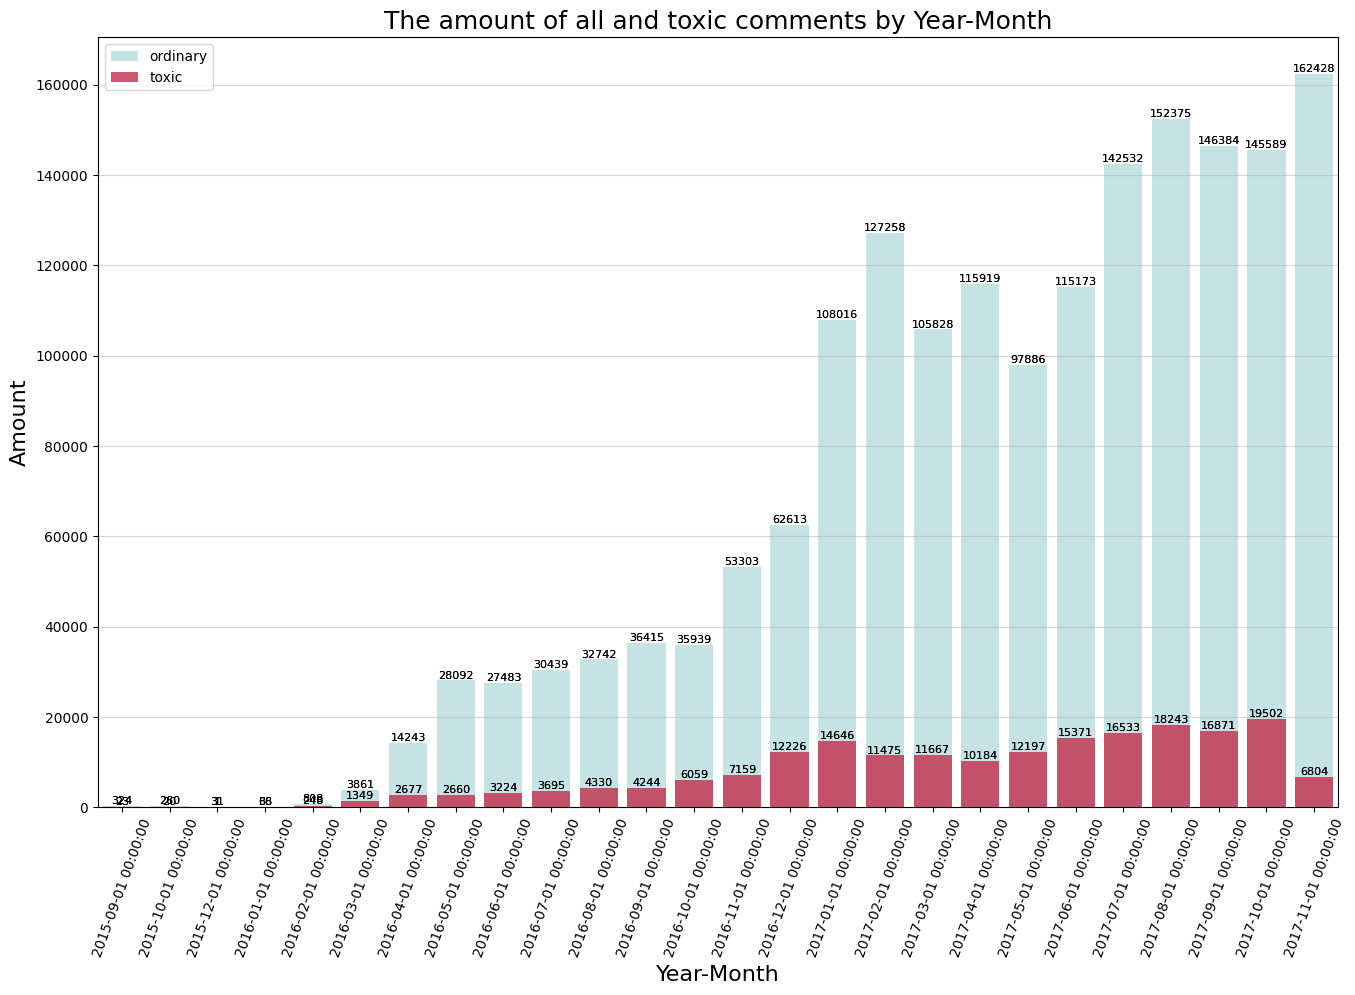

In [90]:
#res = df.groupby('year_month', as_index=False)['comment_text'].count()
plt.figure(figsize=(16, 10))


bar_container_0 = sns.barplot(
    data=(df.groupby('year_month', as_index=False)['comment_text'].count()),
    x='year_month', y='comment_text', label='ordinary', color='powderblue',
    alpha = 0.8
)
bar_container_1 = sns.barplot(
    data=(df[df.toxicity_b == 1].groupby('year_month', as_index=False)['comment_text'].count()),
    x='year_month', y='comment_text', label='toxic', color='crimson',
    alpha = 0.8
)

for p in bar_container_0.patches:
    bar_container_0.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center', va='bottom', 
        fontsize=8, color='black'
    )

for p in bar_container_1.patches:
    bar_container_1.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center', va='bottom', 
        fontsize=8, color='black'
    )


plt.legend()
plt.title('The amount of all and toxic comments by Year-Month', fontsize = 18)
plt.xlabel('Year-Month',fontsize = 16)
plt.ylabel('Amount',fontsize = 16)
plt.grid(axis='y', alpha=0.5)
plt.xticks(rotation=70)
plt.show()

Как можно заметить количество комментариев как всех, так и токсичных имеет тренд по времени на возрастание. Однако есть вероятность, что это просто такой срез данных, где есть дисбаланс по датам. Также видно, что у нас довольно таки мало данных на период с 2015-09 по 2016-02. Возможно стоит удалить такие наблюдения из рассмотрения.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


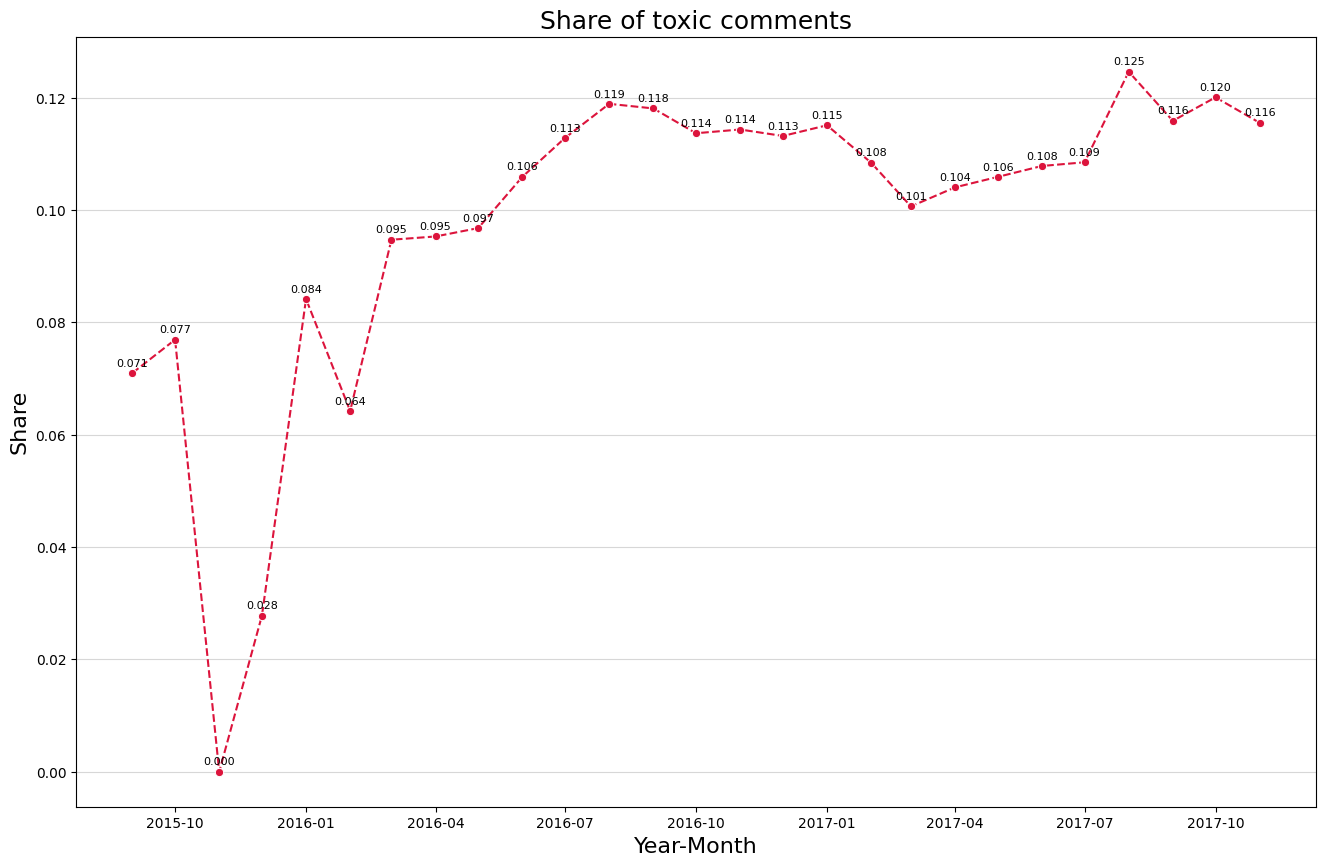

In [91]:
plt.figure(figsize=(16, 10))

sns.lineplot(data = df.groupby('year_month', as_index=False)['toxicity_b'].mean(),
            y = 'toxicity_b', x = 'year_month', linestyle = '--', marker = 'o',
            color='crimson')

for x, y in zip(df.groupby('year_month', as_index=False)['toxicity_b'].mean()['year_month'],
                df.groupby('year_month', as_index=False)['toxicity_b'].mean()['toxicity_b']):
    plt.annotate(
        f'{y:.3f}', 
        (x, y), 
        textcoords="offset points", 
        xytext=(0, 5),  
        ha='center', fontsize=8, color='black'
    )

plt.title('Share of toxic comments', fontsize = 18)
plt.ylabel('Share', fontsize = 16)
plt.xlabel('Year-Month', fontsize = 16)
plt.grid(axis='y', alpha=0.5)
plt.show()

На графике можно наблюдать, что доля токсичных комментариев в данных для периода с 2016-03 по 2016-10 довольно сильно возрастает с 6.4% до 11.79%. После этого периода доля довольно-таки сильно колеблется. В целом этот график подтверждает дисбаланс в данных токсичных и обычных комментариев.

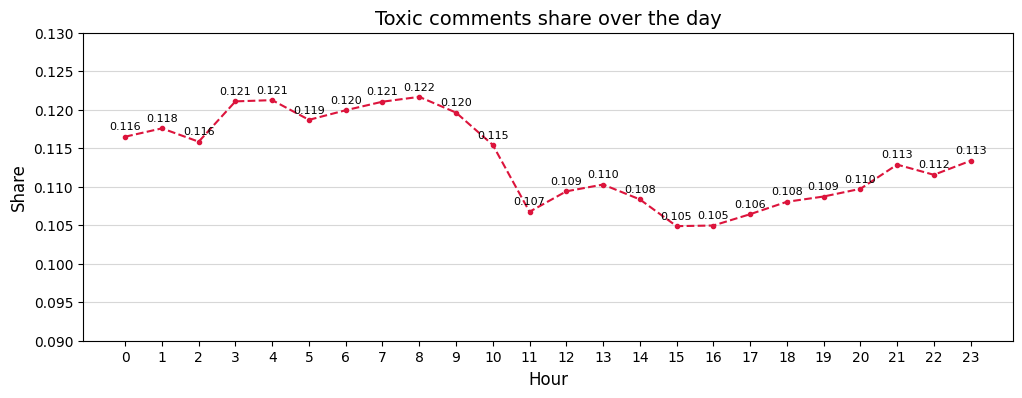

In [92]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot('hour', 'toxicity_b', '.--',
        data=(df.assign(hour=lambda df: df['created_date'].dt.tz_localize(None).dt.hour)
                                    .groupby('hour', as_index=False)['toxicity_b'].mean()),
        color='crimson')

for hour, share in zip(
    df.assign(hour=lambda df: df['created_date'].dt.tz_localize(None).dt.hour)
    .groupby('hour', as_index=False)['toxicity_b'].mean()['hour'], 
    df.assign(hour=lambda df: df['created_date'].dt.tz_localize(None).dt.hour)
    .groupby('hour', as_index=False)['toxicity_b'].mean()['toxicity_b']
):
    ax.annotate(
        f'{share:.3f}',  
        (hour, share), 
        textcoords="offset points", 
        xytext=(0, 5),  
        ha='center', fontsize=8, color='black'
    )

ax.set_title('Toxic comments share over the day', fontsize = 14)
ax.set_xlabel('Hour', fontsize = 12)
ax.set_ylabel('Share', fontsize = 12)
ax.grid(axis='y', alpha=0.5)
ax.set_ylim(bottom=round(ax.get_ybound()[0]*0.9, 2), top=round(ax.get_ybound()[1]*1.1, 2))
ax.set_xticks(np.arange(0, 24, 1))

plt.show()

На графике выше показано изменение доли токсичных комментариев в течении суток. Довольно четко видно, что доля токсичных комментариев в течении дня начинает повышаться с 23:00 достигая пика 11.2% в 8:00. Далее доля токсичных комментариев начинает снижаться в течении дня.

Сделаем срез данных без месяцев, в которых слишком мало наблюдений.

In [93]:
print(df.shape)
df = df[df.year_month > '2016-02']
print(df.shape)

(1804871, 22)
(1799551, 22)


### Анализ количества аннотаторов

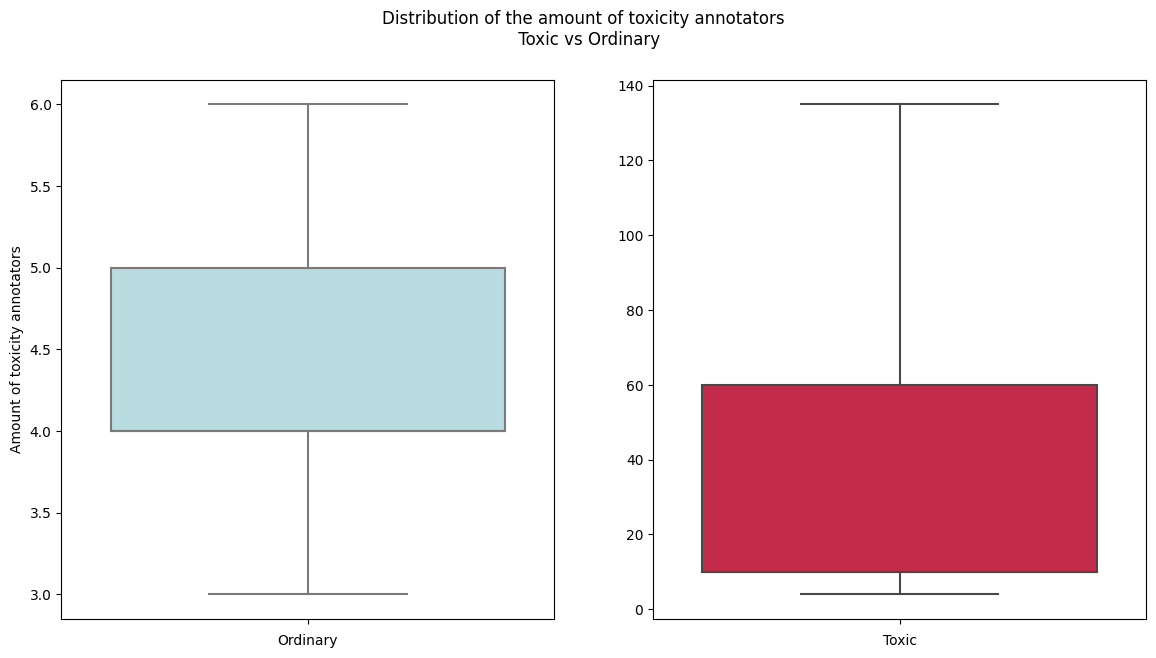

In [94]:
fig, axes = plt.subplots(1,2, figsize = (14, 7))

sns.boxplot(data = df[df.toxicity_b == 0], y = 'toxicity_annotator_count', 
            showfliers=False, color = 'powderblue', ax=axes[0] )

sns.boxplot(data = df[df.toxicity_b == 1], y = 'toxicity_annotator_count', 
            showfliers=False, color = 'crimson', ax=axes[1] )

fig.suptitle('Distribution of the amount of toxicity annotators \n Toxic vs Ordinary')
axes[0].set_ylabel('Amount of toxicity annotators')
axes[1].set_ylabel('')
axes[0].set_xlabel('Ordinary')
axes[1].set_xlabel('Toxic')
plt.show()

Как можно заметить распределение количества аннотаторов довольно-таки сильно отличается для токсичных и обычных комментариев. Количество аннотаторов сильно выше для токсичных комментариев, чем для обычных.

Рассмотрим теперь выбросы в данной переменной. В частности те, которые считаются выбросами для токсичных комментариев.

In [95]:
def cib(data):

    Q1 = data.quantile(0.25)  
    Q3 = data.quantile(0.75)  
    IQR = Q3 - Q1  

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return lower_bound, upper_bound

In [96]:
lb, ub = cib(df[df.toxicity_b == 1].toxicity_annotator_count)

In [97]:
df[(df.toxicity_annotator_count < lb)]

,toxicity,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,created_date,parent_id,rating,...,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,text_length,year,year_month,toxicity_b
id,,,,,,,,,,,,,,,,,,,,,


In [98]:
df[(df.toxicity_annotator_count > ub)].sort_values(by='toxicity_annotator_count', ascending=False).head()

,toxicity,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,created_date,parent_id,rating,...,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,text_length,year,year_month,toxicity_b
id,,,,,,,,,,,,,,,,,,,,,
5118044,0.98,You can stick your dick up anyone's butt. Why ...,0.13,0.94,0.01,0.25,0.01,2017-04-10 23:30:10.076014+00:00,NaN,rejected,...,0,0,0,0.98,0,4936,67,2017,2017-04-01,1
5380193,0.98,I bet your fat bitter little nerd ass was wait...,0.20,0.94,0.02,0.97,0.02,2017-06-08 18:24:06.236150+00:00,5377903.00,rejected,...,0,0,0,0.87,10,4897,132,2017,2017-06-01,1
5292392,0.95,I hope you die today. The world will be much b...,0.25,0.08,0.01,0.76,0.86,2017-05-23 18:10:27.505027+00:00,5292009.00,rejected,...,1,0,1,0.00,0,4177,85,2017,2017-05-01,1
5481314,0.91,Let them die ..\nMaybe we should build concent...,0.28,0.01,0.05,0.10,0.88,2017-06-26 21:37:55.561744+00:00,5480942.00,approved,...,0,4,0,0.00,0,3623,106,2017,2017-06-01,1
5588434,0.94,If we shoot them it will be a permanent soluti...,0.15,0.00,0.03,0.50,0.91,2017-07-13 21:15:03.037890+00:00,5586783.00,rejected,...,0,0,0,0.00,0,3523,88,2017,2017-07-01,1


In [99]:
df[(df.toxicity_annotator_count > ub)].sort_values(by='toxicity_annotator_count', ascending=False).tail()

,toxicity,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,created_date,parent_id,rating,...,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,text_length,year,year_month,toxicity_b
id,,,,,,,,,,,,,,,,,,,,,
5877645,0.87,... does it fold my laundry do the dishes and ...,0.03,0.62,0.00,0.16,0.12,2017-09-01 02:57:19.281959+00:00,NaN,rejected,...,0,0,0,0.87,0,150,63,2017,2017-09-01,1
5996737,0.72,It seems Blacks will defend each other no matt...,0.09,0.00,0.71,0.35,0.01,2017-09-21 23:33:20.724810+00:00,NaN,approved,...,0,6,0,0.01,4,148,144,2017,2017-09-01,1
5457211,0.74,A commie Jew like (((Weintraub))) trying to re...,0.03,0.01,0.64,0.63,0.00,2017-06-22 10:21:07.612455+00:00,NaN,rejected,...,0,0,0,0.00,4,145,126,2017,2017-06-01,1
5958786,0.80,Comparing Obama to Trump is laughable. When y...,0.07,0.10,0.03,0.48,0.00,2017-09-15 15:10:26.051353+00:00,5958445.00,approved,...,0,5,3,0.72,0,145,128,2017,2017-09-01,1
886155,0.74,You realize this isn't a partisan issue right?...,0.03,0.68,0.15,0.39,0.00,2017-01-23 21:05:31.594137+00:00,885603.00,approved,...,0,2,0,0.00,0,143,165,2017,2017-01-01,1


In [100]:
df[(df.toxicity_annotator_count > ub)].shape

(1280, 22)

In [101]:
df[(df.toxicity_annotator_count > ub)].toxicity_b.mean()

0.57578125

In [102]:
df[(df.toxicity_annotator_count > ub)][toxic_cols+['toxicity_annotator_count']].describe([0.05, 0.1, 0.25,0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95,0.99])

,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit,toxicity_annotator_count
count,1280.00,1280.00,1280.00,1280.00,1280.00,1280.00,1280.00,1280.00
mean,0.53,0.08,0.20,0.17,0.34,0.15,0.13,1494.77
std,0.44,0.10,0.33,0.31,0.38,0.31,0.29,478.03
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,143.00
5%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1057.95
10%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1127.00
25%,0.01,0.00,0.00,0.00,0.01,0.00,0.00,1209.00
40%,0.10,0.00,0.00,0.00,0.04,0.00,0.00,1402.00
50%,0.81,0.04,0.01,0.01,0.13,0.00,0.00,1492.00
60%,0.89,0.08,0.03,0.02,0.35,0.00,0.00,1617.00


С виду аномалия для данной переменной вызвана какой-то ошибкой в сборе данных или возможно тем, что разные аннотаторы причисляли комментарии к подтипам токсичности. На текущий момент она не сильно мешает анализу. Поэтому будет решено, что с этим делать чуть позже.

### Анализ Эмодзи и КАПСа

На просторах русского интернета считается, что капс и некоторые определенные эмодзи могут выражать токсичность комментария. Посмотрим применимо ли это к тем комментариям, которые у нас есть.

Начнем пожалуй с эмодзи.

In [103]:
def find_emojis(text):
    
    emoji_pattern = re.compile(
        "[\U0001F600-\U0001F64F"  # Эмодзи с лицами
        "\U0001F300-\U0001F5FF"   # Символы и пиктограммы
        "\U0001F680-\U0001F6FF"   # Транспорт и символы карты
        "\U0001F1E0-\U0001F1FF"   # Флаги (буквы региональных индикаторов)
        "\U00002700-\U000027BF"   # Разные символы
        "\U0001F900-\U0001F9FF"   # Дополнительные эмодзи
        "\U0001FA70-\U0001FAFF"   # Символы и объекты
        "\U00002600-\U000026FF"   # Символы, относящиеся к погоде
        "\U00002B50"              # Звезда
        "\U00002B55"              # Красный круг
        "\U000023E9-\U000023EF"   # Символы управления
        "\U0001F004"              # Символ для маджонга
        "\U0001F0CF"              # Игральные карты джокер
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.findall(text)

In [104]:
df['emoji'] = df.comment_text.apply(find_emojis).apply(lambda x: ''.join(x))

In [105]:
df[df.emoji != ''].shape

(4269, 23)

In [106]:
df[(df.emoji != '')&(df.toxicity_b == 1)].shape

(476, 23)

Как можно заметить в данных довольно мало комментариев, которые содержат в себе эмодзи. В общем наборе это 4269 наблюдения, а для токсичных комментариев это 476 наблюдений. Скорее всего дальнейший анализ эмодзи не имеет смысла.

Теперь перейдем к капсу.

In [107]:
def find_caps_words(text):
    pattern = r'\b[A-Z]{3,}\b' # минимально в слове 3 символо, чтобы избегать аббревиатуры
    return re.findall(pattern, text)

In [108]:
df['caps_wc'] = df.comment_text.apply(find_caps_words)

In [109]:
df[(df.caps_wc.apply(len) != 0)&(df.toxicity_b == 0)].shape

(354533, 24)

В случае со словами с верхним регистром наблюдений довольно много.

In [110]:
df[(df.caps_wc.apply(len) != 0)&(df.toxicity_b == 1)].shape

(46604, 24)

In [111]:
df[df.toxicity_b == 1].shape

(201116, 24)

Да и наблюдений с токсичными комментариями относительно много

Посмотрим на облака слов для обычных и токсичных комментариев.

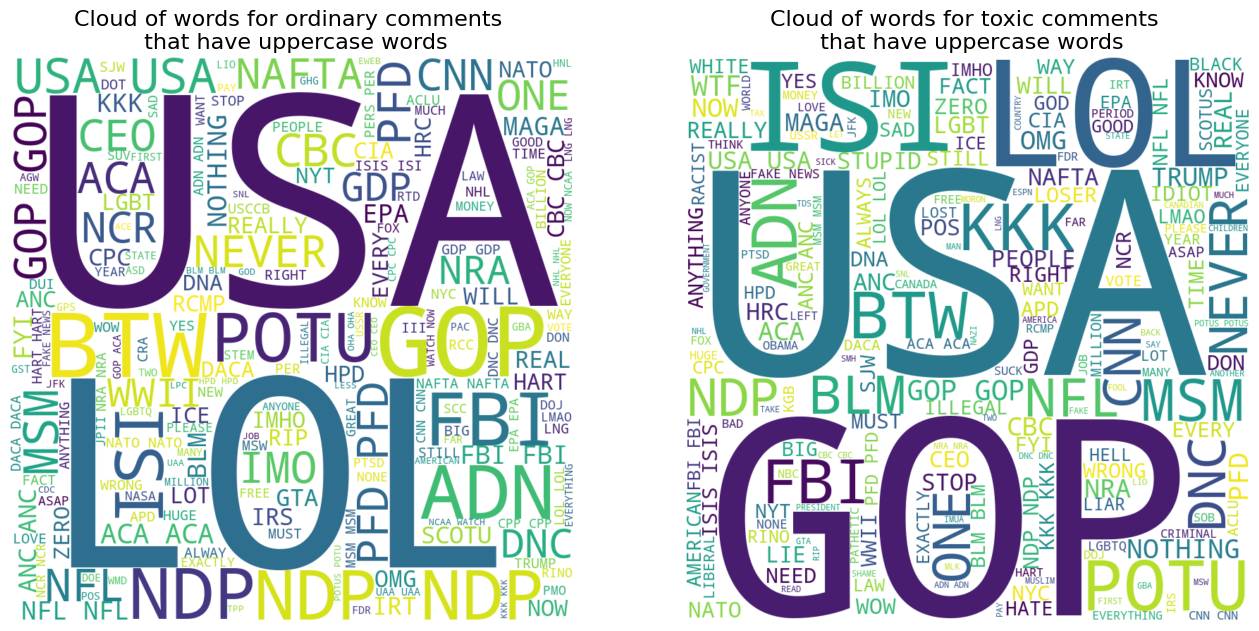

In [112]:
aw1 = [word for caps_w in df[df.toxicity_b == 0]['caps_wc'] for word in caps_w]
aw2 = [word for caps_w in df[df.toxicity_b == 1]['caps_wc'] for word in caps_w]
txt1 = ' '.join(aw1)
txt2 = ' '.join(aw2)

fig, axes =plt.subplots(1,2, figsize = (16, 8))

wc = WordCloud(width=800, height=800, background_color='white', colormap='viridis').generate(txt1)

axes[0].imshow(wc, interpolation="bilinear")
axes[0].axis('off')
axes[0].set_title('Cloud of words for ordinary comments \n that have uppercase words',
                 fontsize = 16)

wc = WordCloud(width=800, height=800, background_color='white', colormap='viridis').generate(txt2)

axes[1].imshow(wc, interpolation="bilinear")
axes[1].axis('off')
axes[1].set_title('Cloud of words for toxic comments \n that have uppercase words',
                 fontsize = 16)
plt.show()

In [113]:
print(round(46604/len(df[df.toxicity_b == 1]), 3))
print(round((354533/len(df[df.toxicity_b == 0])), 3))

0.232
0.222


Попробуем сделать облака слов с только токсичными и не токсичными словами.

In [ ]:
#aw1t = common_elements = [item for item in aw1 if item not in aw2]
#aw2t = common_elements = [item for item in aw2 if item not in aw1]

In [ ]:
txt1 = ' '.join(aw1t)
txt2 = ' '.join(aw2t)

fig, axes =plt.subplots(1,2, figsize = (16, 8))

wc = WordCloud(width=800, height=800, background_color='white', colormap='viridis').generate(txt1)

axes[0].imshow(wc, interpolation="bilinear")
axes[0].axis('off')
axes[0].set_title('Cloud of words for ordinary comments \n that have uppercase words',
                 fontsize = 16)

wc = WordCloud(width=800, height=800, background_color='white', colormap='viridis').generate(txt2)

axes[1].imshow(wc, interpolation="bilinear")
axes[1].axis('off')
axes[1].set_title('Cloud of words for toxic comments \n that have uppercase words',
                 fontsize = 16)
plt.show()

![Результат кода](https://github.com/inreleppik/HSE-Python-for-DA/raw/main/images/download-12.png)

Комментарии со словами с верхним регистром примерно одинаково часто встречаются среди двух видов комментариев. При это большая часть этих слов являются аббревиатурами. Однако, если выделить только токсичные и не токсичные слова, то картина становится более четкой. Возможно это можно будет как-то в будущем использовать для моделей, но это не точно. 


In [ ]:
#del aw1
#del aw2
#del aw1t
#del aw2t
#del txt1
#del txt2

In [114]:
df.drop(columns = ['emoji', 'caps_wc'], inplace=True)

### Анализ наличия ссылок в комментариях

Ещё во время анализа дубликатов было обнаружено, что некоторые комментарии в данных имеют ссылки. Посмотрим имеет ли такая информация какую-либо пользу.

In [115]:
def find_urls(text):
    url_pattern = re.compile(r'(https?://\S+|http://\S+|www\.\S+)')
    return url_pattern.findall(text)

In [116]:
df['url'] = df.comment_text.apply(find_urls).apply(lambda x: ' '.join(x))
df['url_included'] = (df.url.apply(len) != 0).astype(int)

In [121]:
print(df[(df.url_included != 0)&(df.toxicity_b == 0)].shape)
print(round(49870/len(df[df.toxicity_b == 0]), 3))

(49870, 24)
0.031


In [122]:
print(df[(df.url_included != 0)&(df.toxicity_b == 1)].shape)
print(round(3092/len(df[df.toxicity_b == 1]), 3))

(3092, 24)
0.015


In [119]:
df[(df.url_included != 0)&(df.toxicity_b == 0)].url.value_counts()[:10]

url
http://www.cashapp24.com/                                                                                              218
http://www.22moneybay.com                                                                                              115
http://w­w­w­.­c­a­s­h­-s­p­o­t­.­c­o­m                                                                                 76
http://www.jobpro22.com                                                                                                 58
https://docs.google.com/document/d/1DzOz3Y6D8g_MNXHNMJYAz1b41_cn535aU5UsN7Lj8X8/preview#                                56
http://www.factoryofincome.com                                                                                          56
https://www.adn.com/politics/article/series-conoco-employees-help-ease-oil-tax-bill-through-legislature/2013/03/28/     52
https://RiteBeyondRome.com                                                                                              40
https://www.

In [120]:
df[(df.url_included != 0)&(df.toxicity_b == 1)].url.value_counts()[:10]

url
https://www.getcivil.com                                                                                                               22
https://www.youtube.com/watch?v=bi2QKY3zW8Q                                                                                            13
https://docs.google.com/document/d/1DzOz3Y6D8g_MNXHNMJYAz1b41_cn535aU5UsN7Lj8X8/preview#                                                9
https://www.youtube.com/watch?v=SyUDGfCNC-k                                                                                             7
https://www.indivisibleguide.com/web                                                                                                    6
https://www.youtube.com/watch?v=1o6-bi3jlxk                                                                                             6
https://www.youtube.com/watch?v=3un052mvlJI                                                                                             6
https://www.youtube.com/watch?

Наблюдений в которых есть какие-либо ссылки относительно мало как для токсичных, так и для обычных комментариев. 3.1% обычных и 1.5% токсичных комментариев имеют их. Довольно таки интересно то, что наиболее часто повторяющиеся ссылки в токсичных комментариях это ссылки на Youtube видео.

In [123]:
df.drop(columns = ['url', 'url_included'], inplace=True)

### Анализ связи реакций и токсичности

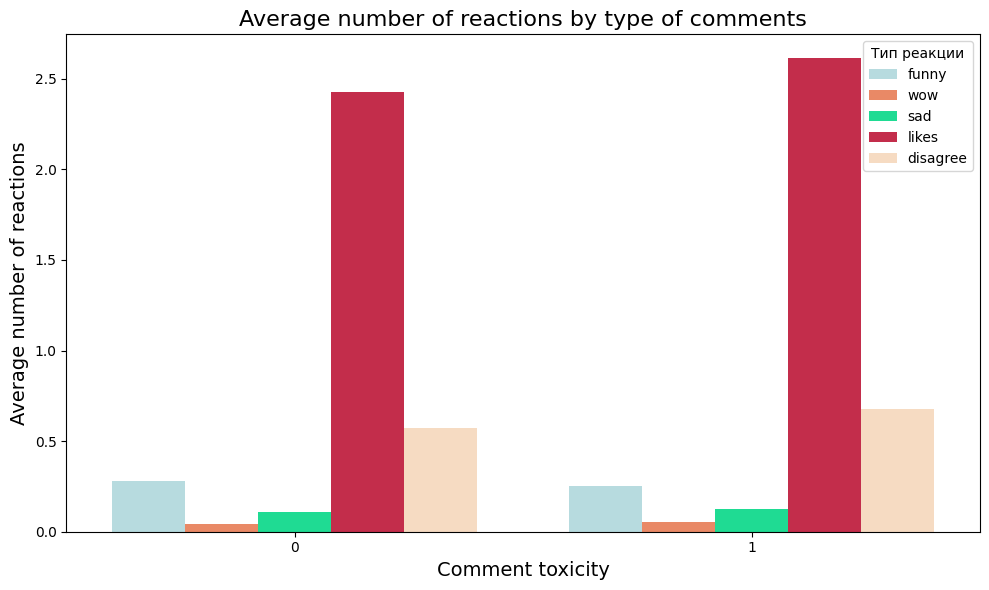

In [124]:
res = df.groupby('toxicity_b')[['funny','wow','sad','likes','disagree']].mean().reset_index()
res = res.melt(
    id_vars='toxicity_b',
    value_vars = ['funny','wow','sad','likes','disagree'],
    var_name = 'Тип реакции',
    value_name = 'Среднее значение'
)
plt.figure(figsize=(10, 6))
sns.barplot(data=res, x='toxicity_b', y='Среднее значение',
            hue='Тип реакции', palette=['powderblue', 'coral', 'mediumspringgreen',
                                        'crimson', 'peachpuff'])

plt.title('Average number of reactions by type of comments', fontsize = 16)
plt.xlabel('Comment toxicity', fontsize = 14)
plt.ylabel('Average number of reactions', fontsize = 14)

plt.tight_layout()
plt.show()

График выше показывает среднее количество различных реакций для обычных и токсичных комментариев. Как можно заметить среднее значения по обоим типам комментариев почти не различается.

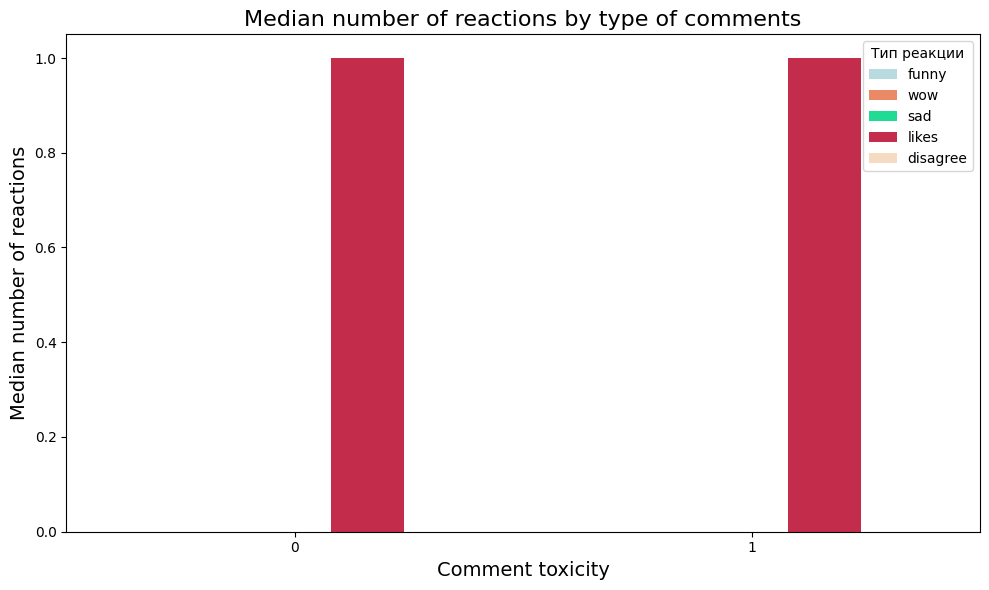

In [125]:
res = df.groupby('toxicity_b')[['funny','wow','sad','likes','disagree']].median().reset_index()
res = res.melt(
    id_vars='toxicity_b',
    value_vars = ['funny','wow','sad','likes','disagree'],
    var_name = 'Тип реакции',
    value_name = 'Медианное значение'
)
plt.figure(figsize=(10, 6))
sns.barplot(data=res, x='toxicity_b', y='Медианное значение',
            hue='Тип реакции', palette=['powderblue', 'coral', 'mediumspringgreen',
                                        'crimson', 'peachpuff'])

plt.title('Median number of reactions by type of comments', fontsize = 16)
plt.xlabel('Comment toxicity', fontsize = 14)
plt.ylabel('Median number of reactions', fontsize = 14)

plt.tight_layout()
plt.show()

В случае с медианными значениями видно, что большая часть комментариев получает в качестве реакций только лайки. Это, на самом деле, соответствует описательным статистикам для данных переменных.

Попробуем объединить все реакции в одну переменную. И посмотрим на описательные статистики по типам комментариев.

In [126]:
df['any_reaction'] = df.funny + df.wow + df.sad + df.likes + df.disagree
df[df.toxicity_b == 0][['any_reaction']].describe([0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95,0.99]).T

,count,mean,std,min,5%,10%,25%,50%,60%,70%,75%,80%,90%,95%,99%,max
any_reaction,1598435.00,3.44,5.93,0.00,0.00,0.00,0.00,2.00,2.00,4.00,4.00,5.00,9.00,13.00,27.00,303.00


In [127]:
df[df.toxicity_b == 1][['any_reaction']].describe([0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95,0.99]).T

,count,mean,std,min,5%,10%,25%,50%,60%,70%,75%,80%,90%,95%,99%,max
any_reaction,201116.00,3.72,6.68,0.00,0.00,0.00,0.00,2.00,2.00,4.00,5.00,6.00,10.00,14.00,29.00,356.00


Смотря на описательные статистики сложно сказать, что имеются какие-либо весомые различия в расппределениях совокупных реакций между токсичными и обычными комментариями. (Скорее нет)

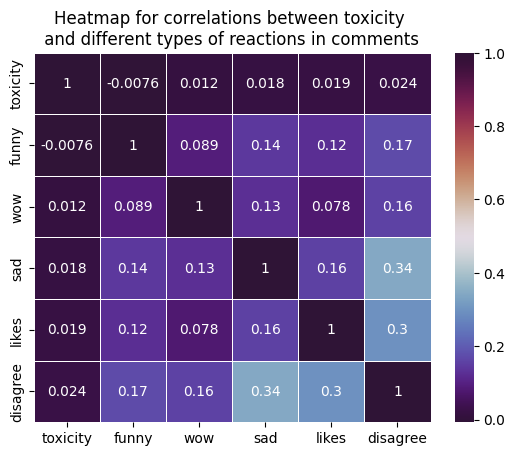

In [128]:
sns.heatmap(df[['toxicity','funny','wow','sad','likes','disagree']].corr(numeric_only=True),
            linewidth=0.5, annot=True, cmap='twilight_shifted',
            linecolor='white')
plt.title('Heatmap for correlations between toxicity \n and different types of reactions in comments ')
plt.show()

Как можно заметить особо сильной корреляции между токсичностью и количеством реакций нет.

Посморим еще на среднее количество реакций по уровням токсичности.

/tmp/ipykernel_30/261711012.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res = df.groupby('toxicity_bins')[['funny','wow','sad','likes','disagree']].mean().reset_index()
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

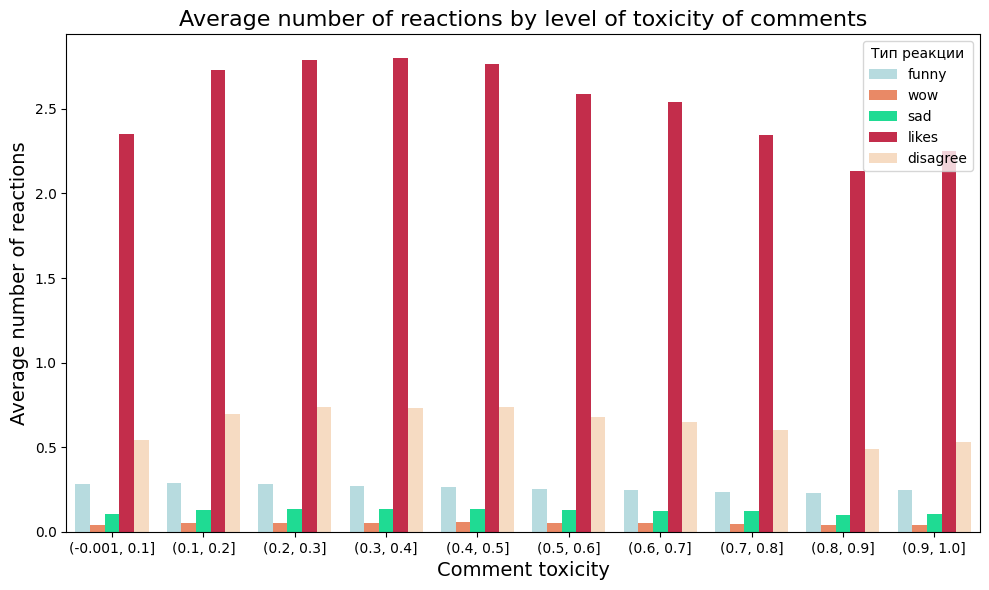

In [129]:
df['toxicity_bins'] = pd.cut(df['toxicity'], bins=10)
res = df.groupby('toxicity_bins')[['funny','wow','sad','likes','disagree']].mean().reset_index()
res = res.melt(
    id_vars='toxicity_bins',
    value_vars = ['funny','wow','sad','likes','disagree'],
    var_name = 'Тип реакции',
    value_name = 'Среднее значение'
)
plt.figure(figsize=(10, 6))
sns.barplot(data=res, x='toxicity_bins', y='Среднее значение', hue='Тип реакции',
            palette=['powderblue', 'coral', 'mediumspringgreen', 'crimson', 'peachpuff'])

plt.title('Average number of reactions by level of toxicity of comments', fontsize = 16)
plt.xlabel('Comment toxicity', fontsize = 14)
plt.ylabel('Average number of reactions', fontsize = 14)


plt.tight_layout()
plt.show()

Какой-то особой разницы здесь тоже не видно.

### Анализ токсичности и её подтипов

Для начала посмотрим на корреляции подтипов токсичности.

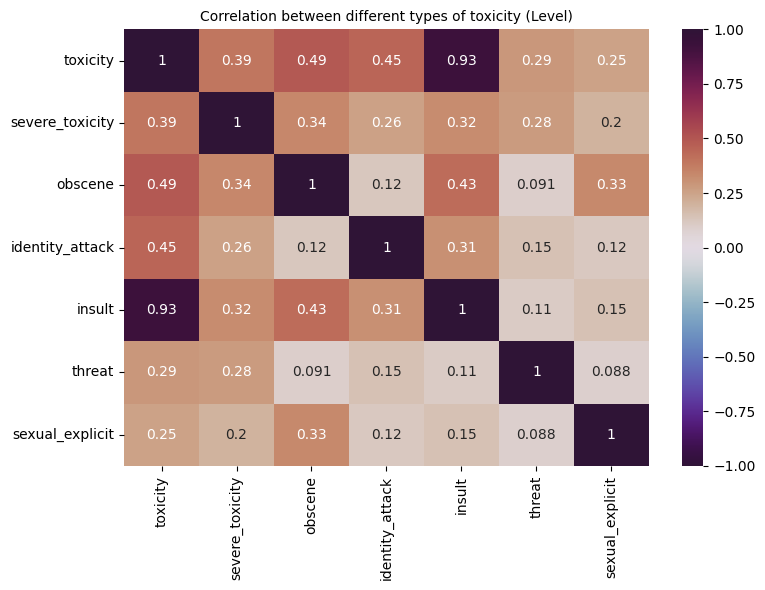

In [130]:
corr_matrix = df[toxic_cols].corr()

plt.figure(figsize=(8, 6))

sns.heatmap(corr_matrix, annot=True, cmap='twilight_shifted', vmin=-1, vmax=1)
plt.title('Correlation between different types of toxicity (Level)', fontsize=10)

plt.tight_layout()
plt.show()

Видно, что переменная `toxicity` наиболее сильно коррелирует с переменной `insult`, а также относительно сильно (не очень) коррелирует с переменными `obscene` и `identity_attack`. Довольно странно, что нет ососбо сильной корреляции между переменными `toxicity` и `severe_toxicity`, так как в описании к данным было указано, что особо токсичные комментарии считаются и просто токсичными. В целом, переменные, которые относятся к подтипам токсичности не сильно коррелируют друг с другом.

Посмотрим теперь на количество комментариев, которые можно причислить к тому или иному подтипу токсичных. Для простоты как и для переменной `toxicity` установим порог 0.4.

In [131]:
b_toxicity_cols = []
b_toxicity_cols.append('toxicity_b')

for col in toxic_cols[1:]:
    df[col+'_b'] = np.where(df[col]>= 0.4, 1, 0)
    b_toxicity_cols.append(col+'_b')

In [132]:
(df[b_toxicity_cols]
 .sum()
 .rename('count')
 .to_frame()
 .assign(total_rows=df.shape[0], share_of_total=lambda df: df['count'] / df['total_rows'])
 .drop(columns=['total_rows']))

,count,share_of_total
toxicity_b,201116,0.11
severe_toxicity_b,75,0.00
obscene_b,13864,0.01
identity_attack_b,24981,0.01
insult_b,151058,0.08
threat_b,7742,0.00
sexual_explicit_b,7938,0.00


In [135]:
df['toxicity_any_kind'] = np.where(df[b_toxicity_cols].sum(axis=1) > 0, 1, 0)
df['toxicity_any_kind'].sum(), df['toxicity_any_kind'].sum() / df.shape[0]

(206560, 0.11478418783352069)

По таблице выше видно, что наблюдений для большей части подтипов токсичности наблюдений довольно мало. Наибольшее количество наблюдений в данных присутствует для переменных `toxicity_b` и `insult_b`. При этом видно, что, если относить комментарии к токсичным учитывая все подтипы токсичности, то наблюдений, которые можно считать токсичными становится больше на 5444. Рассмотрим поподробнее данную ситуацию.

In [136]:
df[(df.toxicity_b == 0)&(df.severe_toxicity_b == 1)]

,toxicity,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,created_date,parent_id,rating,...,toxicity_b,any_reaction,toxicity_bins,severe_toxicity_b,obscene_b,identity_attack_b,insult_b,threat_b,sexual_explicit_b,toxicity_any_kind
id,,,,,,,,,,,,,,,,,,,,,


In [137]:
print(df[(df.toxicity_b == 0)&(df.obscene_b == 1)].shape)
df[(df.toxicity_b == 0)&(df.obscene_b == 1)].head()

(216, 31)


,toxicity,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,created_date,parent_id,rating,...,toxicity_b,any_reaction,toxicity_bins,severe_toxicity_b,obscene_b,identity_attack_b,insult_b,threat_b,sexual_explicit_b,toxicity_any_kind
id,,,,,,,,,,,,,,,,,,,,,
5308547,0.37,They really need a wtf emoji here.,0.01,0.41,0.00,0.14,0.01,2017-05-26 16:05:11.259518+00:00,5308421.00,rejected,...,0,0,"(0.3, 0.4]",0,1,0,0,0,0,1
5289906,0.39,And about to get a RAISE!!!!\n\nW T F ?!?!,0.03,0.44,0.01,0.06,0.00,2017-05-23 03:46:32.412153+00:00,5289531.00,approved,...,0,1,"(0.3, 0.4]",0,1,0,0,0,0,1
5285469,0.40,"""Go f**k yourself.” ~ Vice President Dick Chen...",0.07,0.41,0.01,0.28,0.00,2017-05-21 21:27:25.638667+00:00,5285114.00,approved,...,0,17,"(0.3, 0.4]",0,1,0,0,0,0,1
1036921,0.39,WTF!! No Aces!! It must be the economy at leas...,0.03,0.45,0.00,0.14,0.00,2017-02-23 23:30:16.315402+00:00,NaN,approved,...,0,2,"(0.3, 0.4]",0,1,0,0,0,0,1
6307190,0.36,"Yeah, I'm confused why people act so confused ...",0.09,0.45,0.00,0.36,0.00,2017-11-07 14:22:31.884731+00:00,6306970.00,approved,...,0,2,"(0.3, 0.4]",0,1,0,0,0,0,1


In [138]:
print(216 / 13864)
df[(df.toxicity_b == 0)&(df.obscene_b == 1)].describe()

0.015579919215233698


,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,parent_id,funny,wow,sad,...,year_month,toxicity_b,any_reaction,severe_toxicity_b,obscene_b,identity_attack_b,insult_b,threat_b,sexual_explicit_b,toxicity_any_kind
count,216.00,216.00,216.00,216.00,216.00,216.00,103.00,216.00,216.00,216.00,...,216,216.00,216.00,216.00,216.00,216.00,216.00,216.00,216.00,216.00
mean,0.29,0.02,0.41,0.02,0.14,0.01,3524661.95,0.13,0.02,0.07,...,2017-03-18 17:20:00,0.00,2.55,0.00,1.00,0.00,0.02,0.00,0.03,1.00
min,0.10,0.00,0.40,0.00,0.00,0.00,273098.00,0.00,0.00,0.00,...,2016-03-01 00:00:00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
25%,0.30,0.00,0.40,0.00,0.10,0.00,673597.00,0.00,0.00,0.00,...,2016-12-01 00:00:00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
50%,0.30,0.00,0.40,0.00,0.10,0.00,5130569.00,0.00,0.00,0.00,...,2017-04-01 00:00:00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
75%,0.30,0.00,0.40,0.00,0.20,0.00,5702032.50,0.00,0.00,0.00,...,2017-08-01 00:00:00,0.00,3.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
max,0.40,0.20,0.70,0.40,0.50,0.20,6327993.00,11.00,1.00,2.00,...,2017-11-01 00:00:00,0.00,33.00,0.00,1.00,1.00,1.00,0.00,1.00,1.00
std,0.04,0.04,0.04,0.05,0.11,0.03,2515579.69,0.81,0.15,0.33,...,NaN,0.00,4.43,0.00,0.00,0.07,0.15,0.00,0.16,0.00


In [139]:
print(df[(df.toxicity_b == 0)&(df.identity_attack_b == 1)].shape)
df[(df.toxicity_b == 0)&(df.identity_attack_b == 1)].head()

(1441, 31)


,toxicity,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,created_date,parent_id,rating,...,toxicity_b,any_reaction,toxicity_bins,severe_toxicity_b,obscene_b,identity_attack_b,insult_b,threat_b,sexual_explicit_b,toxicity_any_kind
id,,,,,,,,,,,,,,,,,,,,,
801059,0.39,Yeah big news ADN....so what is going on with ...,0.01,0.00,0.40,0.17,0.12,2017-01-06 19:01:59.022554+00:00,NaN,approved,...,0,3,"(0.3, 0.4]",0,0,1,0,0,0,1
5107794,0.39,Jobs for whites only? Jobs for blacks only? Jo...,0.03,0.00,0.41,0.08,0.00,2017-04-07 22:14:44.590294+00:00,5107712.00,approved,...,0,1,"(0.3, 0.4]",0,0,1,0,0,0,1
1081277,0.39,So on the basis of some bad Catholics you just...,0.04,0.01,0.42,0.16,0.00,2017-03-05 19:42:23.585899+00:00,1081089.00,approved,...,0,1,"(0.3, 0.4]",0,0,1,0,0,0,1
921652,0.36,It's a ban on Muslims.,0.01,0.00,0.42,0.03,0.01,2017-01-30 16:44:51.626105+00:00,920284.00,approved,...,0,1,"(0.3, 0.4]",0,0,1,0,0,0,1
5809199,0.39,The first slave owner in America was BLACK!!!!...,0.01,0.01,0.41,0.11,0.01,2017-08-21 01:41:19.767386+00:00,NaN,approved,...,0,1,"(0.3, 0.4]",0,0,1,0,0,0,1


In [140]:
print(1441 / 24981)
df[(df.toxicity_b == 0)&(df.identity_attack_b == 1)].describe()

0.057683839718185824


,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,parent_id,funny,wow,sad,...,year_month,toxicity_b,any_reaction,severe_toxicity_b,obscene_b,identity_attack_b,insult_b,threat_b,sexual_explicit_b,toxicity_any_kind
count,1441.00,1441.00,1441.00,1441.00,1441.00,1441.00,900.00,1441.00,1441.00,1441.00,...,1441,1441.00,1441.00,1441.00,1441.00,1441.00,1441.00,1441.00,1441.00,1441.00
mean,0.29,0.02,0.01,0.41,0.14,0.02,3936362.03,0.21,0.05,0.16,...,2017-04-15 07:55:40,0.00,3.81,0.00,0.00,1.00,0.02,0.00,0.00,1.00
min,0.10,0.00,0.00,0.40,0.00,0.00,229671.00,0.00,0.00,0.00,...,2016-03-01 00:00:00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
25%,0.30,0.00,0.00,0.40,0.10,0.00,914363.50,0.00,0.00,0.00,...,2017-01-01 00:00:00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
50%,0.30,0.00,0.00,0.40,0.10,0.00,5306418.00,0.00,0.00,0.00,...,2017-05-01 00:00:00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
75%,0.30,0.00,0.00,0.40,0.20,0.00,5807548.00,0.00,0.00,0.00,...,2017-08-01 00:00:00,0.00,5.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
max,0.39,0.20,0.50,0.64,0.70,0.50,6330041.00,11.00,2.00,11.00,...,2017-11-01 00:00:00,0.00,83.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00
std,0.04,0.04,0.04,0.03,0.10,0.05,2389377.45,0.77,0.24,0.62,...,NaN,0.00,7.10,0.00,0.03,0.00,0.14,0.04,0.03,0.00


In [141]:
print(df[(df.toxicity_b == 0)&(df.insult_b == 1)].shape)
df[(df.toxicity_b == 0)&(df.insult_b == 1)].head()

(2786, 31)


,toxicity,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,created_date,parent_id,rating,...,toxicity_b,any_reaction,toxicity_bins,severe_toxicity_b,obscene_b,identity_attack_b,insult_b,threat_b,sexual_explicit_b,toxicity_any_kind
id,,,,,,,,,,,,,,,,,,,,,
6113020,0.39,Are you saying Allie is a loser?,0.01,0.04,0.00,0.40,0.00,2017-10-09 18:06:36.085734+00:00,6110609.00,approved,...,0,0,"(0.3, 0.4]",0,0,0,1,0,0,1
787099,0.39,Get a life people. This is what you spend your...,0.01,0.03,0.01,0.42,0.00,2017-01-04 05:17:44.326163+00:00,NaN,approved,...,0,1,"(0.3, 0.4]",0,0,0,1,0,0,1
354753,0.39,http://www.businessinsider.com/tourists-from-t...,0.01,0.06,0.16,0.40,0.00,2016-06-17 22:18:35.911769+00:00,354750.00,approved,...,0,0,"(0.3, 0.4]",0,0,0,1,0,0,1
5512875,0.39,Which fact do you want me to prove or provide ...,0.01,0.01,0.01,0.40,0.00,2017-07-01 22:03:03.554559+00:00,5512587.00,approved,...,0,4,"(0.3, 0.4]",0,0,0,1,0,0,1
5040485,0.39,"Yeah, right. That's why they tried to sweep th...",0.03,0.13,0.00,0.41,0.00,2017-03-22 21:15:11.396267+00:00,NaN,approved,...,0,0,"(0.3, 0.4]",0,0,0,1,0,0,1


In [142]:
print(2786 / 151058)
df[(df.toxicity_b == 0)&(df.insult_b == 1)].describe()

0.01844324696474202


,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,parent_id,funny,wow,sad,...,year_month,toxicity_b,any_reaction,severe_toxicity_b,obscene_b,identity_attack_b,insult_b,threat_b,sexual_explicit_b,toxicity_any_kind
count,2786.00,2786.00,2786.00,2786.00,2786.00,2786.00,1505.00,2786.00,2786.00,2786.00,...,2786,2786.00,2786.00,2786.00,2786.00,2786.00,2786.00,2786.00,2786.00,2786.00
mean,0.30,0.01,0.02,0.04,0.41,0.01,3762590.88,0.29,0.05,0.13,...,2017-04-06 20:24:27,0.00,4.15,0.00,0.00,0.01,1.00,0.00,0.00,1.00
min,0.10,0.00,0.00,0.00,0.40,0.00,250266.00,0.00,0.00,0.00,...,2016-03-01 00:00:00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
25%,0.30,0.00,0.00,0.00,0.40,0.00,804311.00,0.00,0.00,0.00,...,2017-01-01 00:00:00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
50%,0.30,0.00,0.00,0.00,0.40,0.00,5277324.00,0.00,0.00,0.00,...,2017-05-01 00:00:00,0.00,2.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
75%,0.30,0.00,0.00,0.10,0.40,0.00,5838925.00,0.00,0.00,0.00,...,2017-08-01 00:00:00,0.00,5.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
max,0.40,0.20,0.50,0.50,0.70,0.30,6331964.00,16.00,6.00,6.00,...,2017-11-01 00:00:00,0.00,107.00,0.00,1.00,1.00,1.00,0.00,1.00,1.00
std,0.03,0.03,0.05,0.08,0.02,0.03,2458199.53,1.02,0.26,0.49,...,NaN,0.00,7.36,0.00,0.04,0.10,0.00,0.00,0.03,0.00


In [143]:
print(df[(df.toxicity_b == 0)&(df.threat_b == 1)].shape)
df[(df.toxicity_b == 0)&(df.threat_b == 1)].head()

(220, 31)


,toxicity,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,created_date,parent_id,rating,...,toxicity_b,any_reaction,toxicity_bins,severe_toxicity_b,obscene_b,identity_attack_b,insult_b,threat_b,sexual_explicit_b,toxicity_any_kind
id,,,,,,,,,,,,,,,,,,,,,
667589,0.39,I'm guessing you would not feel like living if...,0.01,0.01,0.00,0.00,0.41,2016-12-06 05:17:05.710481+00:00,665980.00,approved,...,0,1,"(0.3, 0.4]",0,0,0,0,1,0,1
755643,0.39,USDA too. Who needs oversight of anything. Let...,0.03,0.01,0.00,0.03,0.41,2016-12-26 07:28:35.851260+00:00,753822.00,approved,...,0,6,"(0.3, 0.4]",0,0,0,0,1,0,1
509316,0.39,H. Nelson. Stop looking at yourself in the mir...,0.03,0.00,0.00,0.00,0.41,2016-10-05 21:52:16.944760+00:00,509115.00,approved,...,0,0,"(0.3, 0.4]",0,0,0,0,1,0,1
622831,0.30,"He was a troubled, and an institutionalized pe...",0.00,0.00,0.00,0.10,0.40,2016-11-23 18:54:14.768172+00:00,620925.00,approved,...,0,0,"(0.2, 0.3]",0,0,0,0,1,0,1
621759,0.30,If we are PAYING $753 grand for this tournamen...,0.00,0.00,0.00,0.10,0.40,2016-11-23 06:23:28.426964+00:00,NaN,approved,...,0,0,"(0.2, 0.3]",0,0,0,0,1,0,1


In [144]:
print(220 / 7742)
df[(df.toxicity_b == 0)&(df.threat_b == 1)].describe()

0.028416429863084475


,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,parent_id,funny,wow,sad,...,year_month,toxicity_b,any_reaction,severe_toxicity_b,obscene_b,identity_attack_b,insult_b,threat_b,sexual_explicit_b,toxicity_any_kind
count,220.00,220.00,220.00,220.00,220.00,220.00,125.00,220.00,220.00,220.00,...,220,220.00,220.00,220.00,220.00,220.00,220.00,220.00,220.00,220.00
mean,0.30,0.02,0.01,0.03,0.03,0.41,3639033.22,0.20,0.07,0.10,...,2017-03-20 21:22:54,0.00,2.92,0.00,0.00,0.01,0.00,1.00,0.00,1.00
min,0.20,0.00,0.00,0.00,0.00,0.40,247651.00,0.00,0.00,0.00,...,2016-03-01 00:00:00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
25%,0.30,0.00,0.00,0.00,0.00,0.40,657527.00,0.00,0.00,0.00,...,2016-12-01 00:00:00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
50%,0.30,0.00,0.00,0.00,0.00,0.40,5293598.00,0.00,0.00,0.00,...,2017-05-01 00:00:00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
75%,0.30,0.00,0.00,0.00,0.10,0.40,5739736.00,0.00,0.00,0.00,...,2017-08-01 00:00:00,0.00,4.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
max,0.39,0.20,0.20,0.50,0.30,0.60,6329262.00,6.00,2.00,3.00,...,2017-11-01 00:00:00,0.00,44.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00
std,0.02,0.04,0.03,0.07,0.06,0.03,2524960.54,0.70,0.27,0.41,...,NaN,0.00,4.99,0.00,0.00,0.10,0.00,0.00,0.00,0.00


In [145]:
print(df[(df.toxicity_b == 0)&(df.sexual_explicit_b == 1)].shape)
df[(df.toxicity_b == 0)&(df.sexual_explicit_b == 1)].head()

(826, 31)


,toxicity,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,created_date,parent_id,rating,...,toxicity_b,any_reaction,toxicity_bins,severe_toxicity_b,obscene_b,identity_attack_b,insult_b,threat_b,sexual_explicit_b,toxicity_any_kind
id,,,,,,,,,,,,,,,,,,,,,
1031501,0.38,Right. And Bill Clinton never had sex with Mon...,0.03,0.01,0.00,0.05,0.00,2017-02-22 22:06:27.098535+00:00,1031412.00,approved,...,0,14,"(0.3, 0.4]",0,0,0,0,0,1,1
5973974,0.39,"What I recall is the ""virgin undefiled"", as if...",0.03,0.07,0.03,0.16,0.00,2017-09-18 15:41:06.932126+00:00,5972781.00,approved,...,0,14,"(0.3, 0.4]",0,0,0,0,0,1,1
5973628,0.38,A teen having sex with another teen is not a c...,0.00,0.03,0.00,0.06,0.00,2017-09-18 14:44:26.285729+00:00,NaN,approved,...,0,0,"(0.3, 0.4]",0,0,0,0,0,1,1
6132166,0.33,"Ah, so you refuse to take any sort of drug whe...",0.00,0.01,0.01,0.09,0.01,2017-10-12 13:46:58.638347+00:00,6127245.00,approved,...,0,2,"(0.3, 0.4]",0,0,0,0,0,1,1
1073985,0.38,"Actually, that would be you and Blotus. The h...",0.04,0.07,0.04,0.21,0.00,2017-03-03 22:14:22.891276+00:00,1072310.00,approved,...,0,5,"(0.3, 0.4]",0,0,0,0,0,1,1


In [146]:
print(826 / 7938)
df[(df.toxicity_b == 0)&(df.sexual_explicit_b == 1)].describe()

0.10405643738977072


,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,parent_id,funny,wow,sad,...,year_month,toxicity_b,any_reaction,severe_toxicity_b,obscene_b,identity_attack_b,insult_b,threat_b,sexual_explicit_b,toxicity_any_kind
count,826.00,826.00,826.00,826.00,826.00,826.00,535.00,826.00,826.00,826.00,...,826,826.00,826.00,826.00,826.00,826.00,826.00,826.00,826.00,826.00
mean,0.26,0.01,0.04,0.04,0.06,0.01,3655378.32,0.27,0.04,0.09,...,2017-03-29 00:13:56,0.00,3.37,0.00,0.01,0.00,0.00,0.00,1.00,1.00
min,0.00,0.00,0.00,0.00,0.00,0.00,250201.00,0.00,0.00,0.00,...,2016-03-01 00:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
25%,0.20,0.00,0.00,0.00,0.00,0.00,725312.00,0.00,0.00,0.00,...,2016-12-01 00:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
50%,0.30,0.00,0.00,0.00,0.00,0.00,5254499.00,0.00,0.00,0.00,...,2017-05-01 00:00:00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
75%,0.30,0.00,0.10,0.10,0.10,0.00,5921123.50,0.00,0.00,0.00,...,2017-09-01 00:00:00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
max,0.39,0.20,0.40,0.40,0.40,0.20,6333696.00,13.00,5.00,4.00,...,2017-11-01 00:00:00,0.00,43.00,0.00,1.00,1.00,1.00,0.00,1.00,1.00
std,0.07,0.03,0.07,0.07,0.08,0.04,2528186.27,1.03,0.25,0.40,...,NaN,0.00,5.27,0.00,0.08,0.03,0.05,0.00,0.00,0.00


В таблицах выше была рассмотрена ситуация, когда бинарная переменная `toxicity_b == 0`, а другие бинарные переменные отражающие принадлежность к другим подтипам токсичности `== 1`. Видно, что для переменной `severe_toxicity_b` не таких наблюдений, что на самом деле было написано в описании к набору данных. Рассматривая же другие переменные видно, что от 1.5% до 10% наблюдений для разных подтипов токсичности не являются токсичными, если примениять условие `toxicity >= 0.4`. При этом, если рассматривать куски полученных комментариев для разных подтипов, то выглядят они довольно токсично. Да и распределение переменной `toxicity` во всех случаях довольно схож со средним и медианным значением примерно равным `0.3`. Вероятно стоит поподробнее рассмотреть порог того, когда комментарий можно считать токсичным.

## EDA с применением библиотек для работы с NLP

### Анализ длины комментариев

In [ ]:
pandarallel.initialize(progress_bar=True)

df[['text_length', 'num_words', 'num_sent', 'num_punct']] = df['comment_text'].parallel_apply(
    lambda text: (
        len(text),
        len(nltk.tokenize.word_tokenize(text)),
        len(nltk.tokenize.sent_tokenize(text)),
        sum(ch in string.punctuation for ch in text)
    )
).apply(pd.Series)

In [ ]:
df.groupby(by = 'toxicity_b', as_index=False)[['text_length', 'num_words', 'num_sent', 'num_punct']].mean()

In [ ]:
median_length = df[df.toxicity_b == 0].text_length.median()
mean_length = df[df.toxicity_b == 0].text_length.mean()
min_length = df[df.toxicity_b == 0].text_length.min()
max_length = df[df.toxicity_b == 0].text_length.max()
median_length_t = df[df.toxicity_b == 1].text_length.median()
mean_length_t = df[df.toxicity_b == 1].text_length.mean()
min_length_t = df[df.toxicity_b == 1].text_length.min()
max_length_t = df[df.toxicity_b == 1].text_length.max()

txt1 = f"""
Average comment length: {mean_length} \n
Median comment length: {median_length} \n
Min comment length: {min_length} \n
Max comment length: {max_length}
"""
txt2 = f"""
Average comment length: {mean_length_t} \n
Median comment length: {median_length_t} \n
Min comment length: {min_length_t} \n
Max comment length: {max_length_t}
"""

fig, axes = plt.subplots(1,2, figsize = (20, 6))

sns.histplot(data = df[df.toxicity_b == 0], x = 'text_length', ax=axes[0], color = 'powderblue', bins=50)
sns.histplot(data = df[df.toxicity_b == 1], x = 'text_length', ax=axes[1], color = 'crimson', bins = 50)

axes[0].set_xlabel('Number of characters', fontsize = 14)
axes[1].set_xlabel('Number of characters', fontsize = 14)
axes[0].set_ylabel('Count', fontsize = 14)
axes[1].set_ylabel('Count', fontsize = 14)
axes[0].text(0.0, -0.2, txt1, 
            ha='left', va='top', transform=axes[0].transAxes, fontsize=10)
axes[1].text(0.0, -0.2, txt2, 
            ha='left', va='top', transform=axes[1].transAxes, fontsize=10)
axes[0].set_title('Distribution of text length by characters in ordinary comments', fontsize = 16)
axes[1].set_title('Distribution of text length by characters in toxic comments', fontsize = 16)

plt.show()


![Результат кода](https://github.com/inreleppik/HSE-Python-for-DA/raw/main/images/download.png)

In [ ]:
df.groupby('toxicity_b').text_length.describe([0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95])

Распределения длинны комментариев по символам довольно-таки схожи. Однако по хвосту распределения видно, что в обычных комментариях наблюдается больше длинных комментариев (больше 950 символов).

In [ ]:
median_length = df[df.toxicity_b == 0].num_words.median()
mean_length = df[df.toxicity_b == 0].num_words.mean()
min_length = df[df.toxicity_b == 0].num_words.min()
max_length = df[df.toxicity_b == 0].num_words.max()
median_length_t = df[df.toxicity_b == 1].num_words.median()
mean_length_t = df[df.toxicity_b == 1].num_words.mean()
min_length_t = df[df.toxicity_b == 1].num_words.min()
max_length_t = df[df.toxicity_b == 1].num_words.max()

txt1 = f"""
Average comment length: {mean_length} \n
Median comment length: {median_length} \n
Min comment length: {min_length} \n
Max comment length: {max_length}
"""
txt2 = f"""
Average comment length: {mean_length_t} \n
Median comment length: {median_length_t} \n
Min comment length: {min_length_t} \n
Max comment length: {max_length_t}
"""

fig, axes = plt.subplots(1,2, figsize = (20, 6))

sns.histplot(data = df[df.toxicity_b == 0], x = 'num_words', ax=axes[0], color = 'powderblue', bins=50)
sns.histplot(data = df[df.toxicity_b == 1], x = 'num_words', ax=axes[1], color = 'crimson', bins = 50)

axes[0].set_xlabel('Number of words', fontsize = 14)
axes[1].set_xlabel('Number of words', fontsize = 14)
axes[0].set_ylabel('Count', fontsize = 14)
axes[1].set_ylabel('Count', fontsize = 14)
axes[0].text(0.0, -0.2, txt1, 
            ha='left', va='top', transform=axes[0].transAxes, fontsize=10)
axes[1].text(0.0, -0.2, txt2, 
            ha='left', va='top', transform=axes[1].transAxes, fontsize=10)
axes[0].set_title('Distribution of text length by words in ordinary comments', fontsize = 16)
axes[1].set_title('Distribution of text length by words in toxic comments', fontsize = 16)

plt.show()

![Результат кода](https://github.com/inreleppik/HSE-Python-for-DA/raw/main/images/download-1.png)

In [ ]:
df.groupby('toxicity_b').num_words.describe([0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95])

Тут также видно, что распределения весьма схожи. Однко на концах распределения есть выбросы как для токсичных, так и для обычных комментариев.

In [ ]:
median_length = df[df.toxicity_b == 0].num_sent.median()
mean_length = df[df.toxicity_b == 0].num_sent.mean()
min_length = df[df.toxicity_b == 0].num_sent.min()
max_length = df[df.toxicity_b == 0].num_sent.max()
median_length_t = df[df.toxicity_b == 1].num_sent.median()
mean_length_t = df[df.toxicity_b == 1].num_sent.mean()
min_length_t = df[df.toxicity_b == 1].num_sent.min()
max_length_t = df[df.toxicity_b == 1].num_sent.max()

txt1 = f"""
Average comment length: {mean_length} \n
Median comment length: {median_length} \n
Min comment length: {min_length} \n
Max comment length: {max_length}
"""
txt2 = f"""
Average comment length: {mean_length_t} \n
Median comment length: {median_length_t} \n
Min comment length: {min_length_t} \n
Max comment length: {max_length_t}
"""

fig, axes = plt.subplots(1,2, figsize = (20, 6))

sns.histplot(data = df[df.toxicity_b == 0], x = 'num_sent', ax=axes[0], color = 'powderblue', bins=50)
sns.histplot(data = df[df.toxicity_b == 1], x = 'num_sent', ax=axes[1], color = 'crimson', bins = 50)

axes[0].set_xlabel('Number of sentences', fontsize = 14)
axes[1].set_xlabel('Number of sentences', fontsize = 14)
axes[0].set_ylabel('Count', fontsize = 14)
axes[1].set_ylabel('Count', fontsize = 14)
axes[0].text(0.0, -0.2, txt1, 
            ha='left', va='top', transform=axes[0].transAxes, fontsize=10)
axes[1].text(0.0, -0.2, txt2, 
            ha='left', va='top', transform=axes[1].transAxes, fontsize=10)
axes[0].set_title('Distribution of text length by sentences in ordinary comments', fontsize = 16)
axes[1].set_title('Distribution of text length by sentences in toxic comments', fontsize = 16)

plt.show()

![Результат кода](https://github.com/inreleppik/HSE-Python-for-DA/raw/main/images/download-2.png)

In [ ]:
df.groupby('toxicity_b').num_sent.describe([0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95, 0.99])

Тут также можно сказать, что распределения схожи. Однкако видны довольно-таки отчетливые выбросы в данных. Возможно во время считывания предложений `nltk` считал все точки в комментариях.Тут также видно, что распределения весьма схожи.

### Обработка текста

In [ ]:
# Собираем токенизатор со следующими функциями:
# 1. Нормализация документа через unicodedata.normalize('NFKD', x)
# 2. Токенизация через TweetTokenizer из nltk
# 3. Удаление стоп-слов (stopwords('english') из nltk) и знаков пунктуации (string.punctuation) (только токены единичной длины)
# 4. Определение части речи (pos_tag из nltk)
# 5. Лемматизация через WordNetLemmatizer из nltk с указанием части речи

class PreprocessLemmaTokenizer:
    def __init__(self):
        self.wnl = nltk.stem.WordNetLemmatizer()
        self.tknzr = nltk.tokenize.TweetTokenizer()
        self.stopwords = set(nltk.corpus.stopwords.words('english'))
        self.punctuation = set(string.punctuation)

        self.url_re = re.compile(r'(https?://\S+|www\.\S+)', re.IGNORECASE)
        self.symbols_re = re.compile(r'[^a-zA-Zа-яА-Я0-9\s]')
        self.spaces_re = re.compile(r'\s+')

    @staticmethod
    def _normalize(doc):
        return unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    @staticmethod
    def _get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return nltk.corpus.wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return nltk.corpus.wordnet.VERB
        elif treebank_tag.startswith('N'):
            return nltk.corpus.wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return nltk.corpus.wordnet.ADV
        else:
            return nltk.corpus.wordnet.NOUN

    def _clean_txt(self, text):
        # удаление ссылок
        c_t = self.url_re.sub('', text.lower())
        # удаление лишних символов
        c_t = self.symbols_re.sub(' ', c_t)
        c_text = self.spaces_re.sub(' ', c_t).strip()
        return c_text

    def __call__(self, doc):
        clean_doc = self._normalize(self._clean_txt(doc))
        tokens = self.tknzr.tokenize(clean_doc)
        
        # Токенизация, удаление стоп-слов, знаков пунктуации и лемматизация
        pos_tags = nltk.pos_tag(tokens)
        return [
            self.wnl.lemmatize(token, pos=self._get_wordnet_pos(pos_tag))
            for token, pos_tag in pos_tags
            if token.lower() not in self.stopwords and token not in self.punctuation
        ]

In [ ]:
df[['comment_text']][:5].assign(text_tokenized=lambda df: df['comment_text'].apply(PreprocessLemmaTokenizer())).style

In [ ]:
url_re = re.compile(r'(https?://\S+|www\.\S+)', re.IGNORECASE)
symbols_re = re.compile(r'[^a-zA-Zа-яА-Я0-9\s]', re.IGNORECASE)
spaces_re = re.compile(r'\s+')

def clean_and_tokenize_txt(text):
    # Приведение к нижнему регистру и удаление ссылок
    c_text = url_re.sub('', text.lower())
    # Удаление лишних символов и пробелов
    c_text = symbols_re.sub(' ', c_text)
    c_text = spaces_re.sub(' ', c_text).strip()
    # Токенизация
    tokens = [word for word in nltk.word_tokenize(c_text)]
    return tokens, len(tokens)

In [ ]:
pandarallel.initialize(progress_bar=True)

df[['tokens', 'tokens_cnt']] = df['comment_text'].parallel_apply(clean_and_tokenize_txt).apply(pd.Series)

In [ ]:
pandarallel.initialize(progress_bar=True)

df['tokens_ws'] = df['comment_text'].parallel_apply(PreprocessLemmaTokenizer())

In [ ]:
# Сохранение токенизированного фрейма
df.to_csv('/kaggle/working/tokenized_train.csv')

In [ ]:
df = pd.read_csv(
    '/kaggle/working/tokenized_train.csv',
    parse_dates=['created_date'],
    date_format='ISO8601',
    index_col=0
)
df.head()

In [ ]:
df = convert_columns(df)

### Анализ связи между длиной комметариев и их токсичностью

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(y='tokens_cnt', x='toxicity_bins', data=df, hue='toxicity_b', palette=['powderblue', 'crimson'])
plt.title('Connection between comment length and level of toxicity', fontsize=14)
plt.ylabel('Number of words', fontsize=12)
plt.xlabel('Toxicity', fontsize=12)
plt.show()

![Результат кода](https://github.com/inreleppik/HSE-Python-for-DA/raw/main/images/download-3.png)

График показывает, что комментарии с низким уровнем токсичности (до 0.4) обычно длиннее, в среднем около 60 слов, тогда как более токсичные комментарии (с токсичностью выше 0.5) становятся короче. Таким образом, можно сделать вывод, что с ростом уровня токсичности комментарии становятся короче.

### Анализ частоты частей речи

In [ ]:
pos_tags_dict = {
    'NN': 'noun, singular',
    'JJ': 'adjective',
    'NNS': 'noun, plural',
    'RB': 'adverb',
    'VBP': 'verb, present tense, not 3rd person singular',
    'VBG': 'present participle or gerund',
    'VBD': 'verb, past tense',
    'VB': 'infinitive',
    'CD': 'numeral',
    'VBN': 'past participle',
    'IN': 'preposition or subordinating conjunction',
    'VBZ': 'verb, present tense, 3rd person singular',
    'MD': 'modal verb',
    'JJR': 'adjective, comparative',
    'NNP': 'proper noun, singular',
    'PRP': 'personal pronoun',
    'JJS': 'adjective, superlative',
    'DT': 'determiner (article, demonstrative pronoun)',
    'RBR': 'adverb, comparative',
    'FW': 'foreign word',
    'CC': 'coordinating conjunction',
    'RP': 'particle',
    'WDT': 'wh-determiner',
    'UH': 'interjection',
    'WP$': 'wh-possessive pronoun',
    'RBS': 'adverb, superlative',
    '$': 'dollar sign',
    'WRB': 'wh-adverb',
    'NNPS': 'proper noun, plural',
    'WP': 'wh-pronoun',
    'PRP$': 'possessive pronoun',
    'POS': 'possessive ending',
    'EX': 'existential "there"',
    'SYM': 'symbol',
    'TO': 'preposition "to"',
    "''": 'closing quotation mark',
    '``': 'opening quotation mark',
    'PDT': 'predeterminer',
    'LS': 'list item marker'
}

In [ ]:
def process_tokens(tokens):
    pos_tags = nltk.pos_tag(tokens, lang='eng')
    pos = [tag for _, tag in pos_tags]
    return pos

# обработка данных с toxicity_b == 0
all_pos_o = Parallel(n_jobs=-1)(delayed(process_tokens)(tokens) for tokens in df[df.toxicity_b == 0]['tokens_ws'])
all_pos_o = [tag for pos_list in all_pos_o for tag in pos_list]  # Объединение всех списков
pos_cnt_o = Counter(all_pos_o)
translated_counter_o = Counter({pos_tags_dict.get(tag, tag): count for tag, count in pos_cnt_o.items()})

# обработка данных с toxicity_b == 1
all_pos_t = Parallel(n_jobs=-1)(delayed(process_tokens)(tokens) for tokens in df[df.toxicity_b == 1]['tokens_ws'])
all_pos_t = [tag for pos_list in all_pos_t for tag in pos_list]  # Объединение всех списков
pos_cnt_t = Counter(all_pos_t)
translated_counter_t = Counter({pos_tags_dict.get(tag, tag): count for tag, count in pos_cnt_t.items()})

In [ ]:
most_common_pos_o = translated_counter_o.most_common(20)
most_common_pos_t = translated_counter_t.most_common(20)

fig, axes = plt.subplots(1,2, figsize = (20, 8))

sns.barplot(
    y=[pos for pos, _ in most_common_pos_o],
    x=[count for _, count in most_common_pos_o]
,ax = axes[0], color = 'powderblue')

sns.barplot(
    y=[pos for pos, _ in most_common_pos_t],
    x=[count for _, count in most_common_pos_t]
,ax = axes[1], color = 'crimson')

axes[0].set_title('Frequency of parts of speech (excluding stop words) for ordinary comments',
                 fontsize = 14)
axes[1].set_title('Frequency of parts of speech (excluding stop words) for toxic comments',
                 fontsize = 14)
axes[0].set_ylabel('Part of speech', fontsize = 12)
axes[1].set_ylabel('Part of speech', fontsize = 12)

axes[0].set_xlabel('Number', fontsize = 14)
axes[1].set_xlabel('Number', fontsize = 14)

plt.tight_layout()
plt.show()

![Результат кода](https://github.com/inreleppik/HSE-Python-for-DA/raw/main/images/download-4.png)

### Анализ слов в токсичных и обычных комментариях

In [ ]:
def extract_features(tokens_series, ngram_sizes=(2, 3)):
    # Объявляем уникальные слова и n-граммы
    unique_words = set(chain.from_iterable(tokens_series))
    unique_ngrams = {n: set() for n in ngram_sizes}

    # Функция для извлечения n-грамм из одного набора токенов
    def extract_ngrams(tokens, n):
        return {' '.join(gram) for gram in nltk.ngrams(tokens, n)}

    # Параллельная обработка каждого размера n-граммы для каждого набора токенов
    for n in ngram_sizes:
        ngrams_for_size = Parallel(n_jobs=-2)(delayed(extract_ngrams)(tokens, n) for tokens in tokens_series if len(tokens) >= n)
        # Объединяем все уникальные n-граммы для текущего размера n
        unique_ngrams[n].update(set(chain.from_iterable(ngrams_for_size)))

    return unique_words, unique_ngrams

# non-toxic
tokens_non_toxic = df.loc[df.toxicity_b == 0, 'tokens_ws']
uawo, ngrams_non_toxic = extract_features(tokens_non_toxic)
bos = list(ngrams_non_toxic[2])
tos = list(ngrams_non_toxic[3])

# toxic
tokens_toxic = df.loc[df.toxicity_b == 1, 'tokens_ws']
uawt, ngrams_toxic = extract_features(tokens_toxic)
bts = list(ngrams_toxic[2])
tts = list(ngrams_toxic[3])

uawo = list(uawo)
uawt = list(uawt)

In [ ]:
df['ctws'] = df.tokens_ws.progress_apply(lambda x: ' '.join(x))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_tfd(unique_tokens, cleaned_com_t, gram):
    # Определяем параметр ngram_range для CountVectorizer
    if gram >= 2:
        vectorizer = CountVectorizer(vocabulary=unique_tokens, ngram_range=(gram, gram))
    else:
        vectorizer = CountVectorizer(vocabulary=unique_tokens)
    
    # Функция для обработки части данных
    def process_chunk(chunk):
        X_chunk = vectorizer.fit_transform(chunk)
        return np.asarray(X_chunk.sum(axis=0))[0]
    
    # Распараллеливаем обработку частей
    n_jobs = -2  # Используем все ядра, кроме двух
    chunk_size = len(cleaned_com_t) // (abs(n_jobs) * 2)  # Разбиваем на части по количеству потоков
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_chunk)(cleaned_com_t[i:i + chunk_size]) 
        for i in range(0, len(cleaned_com_t), chunk_size)
    )
    
    # Объединяем результаты
    total_counts = np.sum(results, axis=0)
    return dict(zip(vectorizer.get_feature_names_out(), total_counts))

In [ ]:
token_frequency_dict1 = get_tfd(uawo, df[df.toxicity_b == 0]['ctws'], 1)
token_frequency_dict12 = get_tfd(uawt, df[df.toxicity_b == 1]['ctws'], 1)
token_frequency_dict2 = get_tfd(bos, df[df.toxicity_b == 0]['ctws'], 2)
token_frequency_dict22 = get_tfd(bts, df[df.toxicity_b == 1]['ctws'], 2)
token_frequency_dict3 = get_tfd(tos, df[df.toxicity_b == 0]['ctws'], 3)
token_frequency_dict32 = get_tfd(tts, df[df.toxicity_b == 1]['ctws'], 3)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (20, 20))

sns.barplot(data=(pd.DataFrame
              .from_records(sorted(token_frequency_dict1.items(), key=lambda x: x[1], reverse=True)[:30],
                            columns=['word', 'count'])), x='count', y = 'word', ax = axes[0][0],
           color = 'powderblue')
sns.barplot(data=(pd.DataFrame
              .from_records(sorted(token_frequency_dict12.items(), key=lambda x: x[1], reverse=True)[:30],
                            columns=['word', 'count'])), x='count', y = 'word', ax = axes[0][1],
           color = 'crimson')

wc = (WordCloud(width=800, height=800, max_words=400, background_color='white')
              .generate_from_frequencies(token_frequency_dict1))
axes[1][0].imshow(wc, interpolation="bilinear")
axes[1][0].axis('off')

wc = (WordCloud(width=800, height=800, max_words=400, background_color='white')
              .generate_from_frequencies(token_frequency_dict12))
axes[1][1].imshow(wc, interpolation="bilinear")
axes[1][1].axis('off')

fig.suptitle("Bar plots and Clouds of words for TOP-30 words in comments \n Ordinary vs Toxic", fontsize = 20)
axes[0][0].set_title('Ordinary', fontsize = 16)
axes[0][1].set_title('Toxic', fontsize = 16)
axes[1][0].set_title('Ordinary', fontsize = 16)
axes[1][1].set_title('Toxic', fontsize = 16)
axes[0][0].set_ylabel('Word', fontsize = 14)
axes[0][1].set_ylabel('Word', fontsize = 14)
axes[0][0].set_xlabel('Number', fontsize = 14)
axes[0][1].set_xlabel('Number', fontsize = 14)

plt.show()

![Результат кода](https://github.com/inreleppik/HSE-Python-for-DA/raw/main/images/download-5.png)

На графике выше сравниваются наиболее часто встречающиеся слова в токсичных и обычных комментариях. В обоих типах комментариев наиболее часто употребляемые слова включают такие как `"people"`, `"get"`, `"like"`, `"go"` и `"trump"`, однако в токсичных комментариях более заметны слова с негативным оттенком, такие как `"stupid"`, `"kill"`, `"right"` и `"woman"`. Это говорит о том, что токсичные комментарии часто включают слова, связанные с агрессией, осуждением и негативными оценками, тогда как обычные комментарии содержат более нейтральные и общие выражения.

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (20, 20))

sns.barplot(data=(pd.DataFrame
              .from_records(sorted(token_frequency_dict2.items(), key=lambda x: x[1], reverse=True)[:30],
                            columns=['word', 'count'])), x='count', y = 'word', ax = axes[0][0],
           color = 'powderblue')
sns.barplot(data=(pd.DataFrame
              .from_records(sorted(token_frequency_dict22.items(), key=lambda x: x[1], reverse=True)[:30],
                            columns=['word', 'count'])), x='count', y = 'word', ax = axes[0][1],
           color = 'crimson')

wc = (WordCloud(width=800, height=800, max_words=400, background_color='white')
              .generate_from_frequencies(token_frequency_dict2))
axes[1][0].imshow(wc, interpolation="bilinear")
axes[1][0].axis('off')

wc = (WordCloud(width=800, height=800, max_words=400, background_color='white')
              .generate_from_frequencies(token_frequency_dict22))
axes[1][1].imshow(wc, interpolation="bilinear")
axes[1][1].axis('off')

fig.suptitle("Bar plots and Clouds of bigrams for TOP-30 bigrams in comments \n Ordinary vs Toxic", fontsize = 20)
axes[0][0].set_title('Ordinary', fontsize = 16)
axes[0][1].set_title('Toxic', fontsize = 16)
axes[1][0].set_title('Ordinary', fontsize = 16)
axes[1][1].set_title('Toxic', fontsize = 16)
axes[0][0].set_ylabel('Bigram', fontsize = 14)
axes[0][1].set_ylabel('Bigram', fontsize = 14)
axes[0][0].set_xlabel('Number', fontsize = 14)
axes[0][1].set_xlabel('Number', fontsize = 14)

plt.show()

![Результат кода](https://github.com/inreleppik/HSE-Python-for-DA/raw/main/images/download-6.png)

На графике выше представлены биграммы, которые наиболее часто встречаются в обычных и токсичных комментариях. В обычных комментариях популярны нейтральные и общественно-политические темы, такие как `"health care"`, `"year ago"`, `"climate change"`, `"united states"` и `"income tax"`. В токсичных комментариях встречаются выражения с негативной или агрессивной окраской, такие как `"white supremacist"`, `"look like"`, `"go back"`, `"get rid"`, и `"right wing"`. Это указывает на то, что в токсичных комментариях люди более склонны к политическим и социальным нападкам, обсуждению чувствительных тем и выражению негативных взглядов, в то время как в обычных комментариях люди ориентированы на более обобщённые темы.

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (30, 20))

sns.barplot(data=(pd.DataFrame
              .from_records(sorted(token_frequency_dict3.items(), key=lambda x: x[1], reverse=True)[:30],
                            columns=['word', 'count'])), x='count', y = 'word', ax = axes[0][0],
           color = 'powderblue')
sns.barplot(data=(pd.DataFrame
              .from_records(sorted(token_frequency_dict32.items(), key=lambda x: x[1], reverse=True)[:30],
                            columns=['word', 'count'])), x='count', y = 'word', ax = axes[0][1],
           color = 'crimson')

wc = (WordCloud(width=1000, height=600, max_words=400, background_color='white')
              .generate_from_frequencies(token_frequency_dict3))
axes[1][0].imshow(wc, interpolation="bilinear")
axes[1][0].axis('off')

wc = (WordCloud(width=1000, height=600, max_words=400, background_color='white')
              .generate_from_frequencies(token_frequency_dict32))
axes[1][1].imshow(wc, interpolation="bilinear")
axes[1][1].axis('off')

fig.suptitle("Bar plots and Clouds of trigrams for TOP-30 trigrams in comments \n Ordinary vs Toxic", fontsize = 20)
axes[0][0].set_title('Ordinary', fontsize = 16)
axes[0][1].set_title('Toxic', fontsize = 16)
axes[1][0].set_title('Ordinary', fontsize = 16)
axes[1][1].set_title('Toxic', fontsize = 16)
axes[0][0].set_ylabel('Trigram', fontsize = 14)
axes[0][1].set_ylabel('Trigram', fontsize = 14)
axes[0][0].set_xlabel('Number', fontsize = 14)
axes[0][1].set_xlabel('Number', fontsize = 14)

plt.show()

![Результат кода](https://github.com/inreleppik/HSE-Python-for-DA/raw/main/images/download-7.png)

Говоя про графики триграмм, в обычных комментариях популярные триграммы включают такие нейтральные выражения, как `"would like see"`, `"new york time"`, `"health care system"` и `"make america great"`. В токсичных же комментариях часто встречаются триграммы с агрессивным или провокационным подтекстом, такие как `"make america great"`, `"black life matter"`, `"nazi white supremacist"` и `"social justice warrior"`. В целом, выводы остаются теми же, что и для графиков биграмм.

In [ ]:
mport matplotlib.ticker as ticker


def calculate_frequencies(vectorizer, df, tokenized_text_column):
    X = vectorizer.fit_transform(df[tokenized_text_column])
    return dict(zip(vectorizer.get_feature_names_out(), np.asarray(X.sum(axis=0))[0]))

def generate_wordcloud(freq_dict, top_N_set_other, N_for_clouds, color_map):
    top_words = {key: freq_dict[key] for key in (set(freq_dict.keys()) - top_N_set_other)}
    return WordCloud(width=800, height=500, max_words=N_for_clouds, background_color='white', colormap=color_map).generate_from_frequencies(top_words)

def split_compare(df, tokenized_text_column, token_sep, split_column, threshold, ngram_range=(1, 1)):
    '''
    Splits dataset 'df' by 'threshold' value of 'split_column'
    Generates plots to compare corpuses of splitted subsets

    Parameters:
    -----------
    df: pandas.DataFrame - dataset to split
    tokenized_text_column: str - text column to analyze (assuming to be already tokenized and joined by 'token_sep')
    token_sep: str - token separator in tokenized text
    split_column: - column to split dataset by
    threshold: Union[int, float] - value to split by
    ngram_range: tuple[int, int] - ngram_range in format accepted by CountVectorizer from sklearn
    '''
    N_for_hbars = 40
    N_for_clouds = 200

    # Initialize vectorizer
    vectorizer = CountVectorizer(
        ngram_range=ngram_range,
        tokenizer=lambda x: x.split(token_sep),
        strip_accents=None,
        lowercase=False,
        preprocessor=None,
        stop_words=None,
        token_pattern=None
    )

    # Parallel computation of frequencies for left and right splits
    freq_dict_left, freq_dict_right = Parallel(n_jobs=2)([
        delayed(calculate_frequencies)(vectorizer, df[df[split_column] < threshold], tokenized_text_column),
        delayed(calculate_frequencies)(vectorizer, df[df[split_column] >= threshold], tokenized_text_column)
    ])

    # Top N sets for word clouds
    top_N_set_left = set(x[0] for x in sorted(freq_dict_left.items(), key=lambda x: x[1], reverse=True)[:N_for_clouds])
    top_N_set_right = set(x[0] for x in sorted(freq_dict_right.items(), key=lambda x: x[1], reverse=True)[:N_for_clouds])

    # Parallel generation of word clouds for left and right splits
    wc_left, wc_right = Parallel(n_jobs=2)([
        delayed(generate_wordcloud)(freq_dict_left, top_N_set_right, N_for_clouds, 'winter'),
        delayed(generate_wordcloud)(freq_dict_right, top_N_set_left, N_for_clouds, 'gist_heat')
    ])

    # Plotting
    fig = plt.figure(figsize=(16, 10), layout='constrained')

    # gridspec for 2 rows of axes
    gs0 = fig.add_gridspec(2, 1)

    # Will be 2 axes in the 1st row and 2 in the 2nd row
    gs00 = gs0[0].subgridspec(1, 2)
    ax11 = fig.add_subplot(gs00[0, 0])  # Axes for negative labeled freq bar
    ax12 = fig.add_subplot(gs00[0, 1])  # Axes for positive labeled freq bar

    gs01 = gs0[1].subgridspec(1, 2)
    ax21 = fig.add_subplot(gs01[0, 0])  # Axes for negative labeled word cloud
    ax22 = fig.add_subplot(gs01[0, 1])  # Axes for positive labeled word cloud

    # 1st row of axes: plotting frequency bars
    for ax, label, freq_dict, colo in zip([ax11, ax12], ['negative', 'positive'], [freq_dict_left, freq_dict_right], ['powderblue', 'crimson']):
        ax.barh('word', 'count', data=pd.DataFrame.from_records(
            sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:N_for_hbars], columns=['word', 'count']),color = colo)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda val, pos: f'{val / 10**3:.0f}K'))
        ax.invert_yaxis()
        ax.set_title(f'top {N_for_hbars} from {label} labeled corpus')

    # 2nd row of axes: plotting word clouds
    for ax, img, label in zip([ax21, ax22], [wc_left, wc_right], ['negative', 'positive']):
        ax.axis('off')
        ax.imshow(img)
        ax.set_title(f'top {N_for_clouds} from {label} labeled corpus w/o union')

    fig.suptitle('Comparison of Text Features by Corpus')
    plt.show()


In [ ]:
df['ctws'] = df.tokens_ws.progress_apply(lambda x: '$'.join(x))

In [ ]:
split_compare(df, tokenized_text_column='ctws', token_sep='$', split_column='toxicity', threshold=0.4, ngram_range=(2, 2))

![Результат кода](https://github.com/inreleppik/HSE-Python-for-DA/raw/main/images/download-9.png)

In [ ]:
split_compare(df, tokenized_text_column='ctws', token_sep='$', split_column='toxicity', threshold=0.4, ngram_range=(3, 3))

![Результат кода](https://github.com/inreleppik/HSE-Python-for-DA/raw/main/images/download-10.png)

In [ ]:
split_compare(df, tokenized_text_column='ctws', token_sep='$', split_column='toxicity', threshold=0.4, ngram_range=(3, 3))

![Результат кода](https://github.com/inreleppik/HSE-Python-for-DA/raw/main/images/download-11.png)